# Conditional Subspace Variational Autoencoder (CSVAE) with Heterogenous Attribute Likelihood (H-CSVAE)

The CSVAE is an extension of the VAE that explicitly disentangles the latent space into dimensions which correspond to variation among the different classes and dimensions which capture the variation in the data that is irrelevant for class differentiation. For example, the dataset might be images of people's faces and the labels might be glasses vs no glasses. The CSVAE encodes each observation into a latent representation $(\mathbf{z}, \mathbf{w})$ where changing $\mathbf{w}$ and decoding affects whether the decoded image has glasses and changing $\mathbf{z}$ affects attributes not related to glasses such as hairstyle, facial hair, etc. CSVAEs can be used to produce "counterfactual" examples of an observation that are "what the example would look like if it were a member of the other class". This is done by encoding an example, fixing $\mathbf{z}$, and modifying $\mathbf{w}$ to be in the region of latent space corresponding to the target class, and decoding $(\mathbf{z}, \mathbf{w})$. Many of the datasets for which one would want to produce a "counterfactual" example are tabular and have heterogenous statistical attributes. Hence the need to provide a likelihood model that can explicitly account for data with heterogenous attributes.

This notebook presents a modification of the CSVAE likelihood which explicitly accounts for these different data types.  Three examples are presented. 

As the PyTorch distributions package abstracts away the details of the underlying log likelihoods for the different distributions considered, we do not discuss the explicit likelihood calculations.


## Table of Contents:
1. [Statistical Data Types](#statistical-data-types)
2. [CSVAE Derivation](#vae-derivation)
3. [Inspection and Debugging Functions](#inspection-debugging)
4. [H-CSVAE Implementation](#hcsvae-implementation)
5. [Complicated mixed real-categorical example](#example1)
6. [Dataset with all 7 data types example](#example2)
7. [Real Dataset (South German Credit) example](#example3)

## Statistical Data Types <a class="anchor" id="statistical-data-types"></a>

The different types of tabular data include:

* Binary: A discrete outcome data type with exactly two possible outcomes. For example, yes/no, true/false, etc. There is no sense of ordering for these outcomes.

Modelled with a Bernoulli distribution where the probability of success is a function (deep neural network) of the latent representation $\mathbf{z}$. That is, $x \sim Ber(p_{\theta} (\mathbf{z}))$

* Categorical: A discrete outcome data type with more than two possible outcomes. For example, red/green/blue. There is no sense of ordering for these outcomes.

Modelled with a Categorical distribution where the probability vector is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network: $x \sim Cat(p_{\theta} (\mathbf{z}))$

* Ordinal: A discrete outcome data type where there is some sense of ordering among the outcomes. For example, bad/neutral/good or freezing/cold/comfortable/warm/hot. 

This data type is modelled with an ordinal logit model, which is a type of censored data process. 

For an ordinal logit model with K categories, it is assumed that there is an unobserved continuous variable $y^*$ and the positive real line is partitioned by K-1 thresholds. The regions between the thresholds are the K categories. Wherever $y^*$ lands is the ordinal category that is observed. 

We assume that the probability that the ordinal category R is less than or equal to r is 

\begin{equation}
Pr(R \le r) = \sigma(g_{\theta}^r(\mathbf{z}) - h_{\theta}(\mathbf{z}))
\end{equation}

where $\sigma$ is the standard logistic function, $g^{r}_{\theta}$ is a deep neural network determining the $rth$ threshold, and $ h_{\theta}$ is a function determining where the censored variable lands. Then the probabilities for each ordinal category are determined via:

\begin{equation}
p(R=r) = Pr(R \le r) - Pr(R \le r-1)
\end{equation}

and are used as the parameters for a categorical distribution. The output of the "decoder" has K values: K-1 thresholds values and the "latent" random variable. A softplus activation function is applied to the threshold values and then are cumulatively summed in order to enforce positivity and monotonicity. 

\begin{equation}
D_{\theta}(\mathbf{z}) = [h_{\theta}(\mathbf{z}), \text{softplus}(g^1_{\theta}(\mathbf{z}) ), \text{softplus}(g^1_{\theta}(\mathbf{z}) ) + \text{softplus}(g^2_{\theta}(\mathbf{z}) ), ..., \text{softplus}(g^1_{\theta}(\mathbf{z}) ) + ... + \text{softplus}(g^{K-1}_{\theta}(\mathbf{z}) ) ]
\end{equation}

* Bounded Count: A nonnegative integer valued data type that has an upper bound. I.e, takes on the values 0, 1, 2, ..., N.

Modelled with a Binomial distribution where the probability of success is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim Bin(p_{\theta} (\mathbf{z}), N)$ where N is assumed to be known.

* Unbounded Count: A nonnegative integer that has no upper bound. I.e, takes on the values 0, 1, 2, ...

Modelled with a Poisson distribution where the rate is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim Pois(\lambda_{\theta} (\mathbf{z}))$.

* Positive Real: A positive real number. I.e. takes on a value in the interval $(0, \infty)$

Modelled with a lognormal distribution where the mean is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim lognormal(\mu_{\theta} (\mathbf{z}), \sigma^2)$ where $\sigma^2$ is assumed to be known.

* Real: A real number. I.e. takes on a value in the interval $(-\infty, \infty)$.

Modelled with a normal distribution where the mean is the output of the latent representation $\mathbf{z}$ transformed by a deep neural network. $x \sim normal(\mu_{\theta} (\mathbf{z}), \sigma^2)$ where $\sigma^2$ is assumed to be known.



### Normalization Strategies

* Real: Standardize
* Lognormal: Standardize in log space. Can also just take log and treal as real-valued. 
Note: PyTorch computes the log_prob of the lognormal distribution by taking the log of the input and computing the normal log prob times a Jacobian determinant scaling factor
* Count / Binomial: When count is small, do not normalize. When count is large, approximate as real. 


### Other Notes

All components of the H-CSVAE likelihood are conditionally independent given $\mathbf{z}$.

## CSVAE Derivation <a class="anchor" id="csvae-derivation"></a>

### Definitions

#### Entropy

Entropy is a property of a probability distribution. One interpretation is that it's a measure of how "random" the distribution is e.g. a uniform distribution is more random than a distribution with most of its mass concentrated around a single number. Entropy for continuous distributions is often known as "differential entropy".

$$
H(p) = - \mathbb{E}_{p} \left[\log p \right] = -\int p(x)\log(p(x))dx
$$

#### KL Divergence

The KL divergence is a discrepancy measure between two probability distributions and is used as an optimization objective in variational inference to find the variational parameters that make the variational distribution as close as possible to the target distribution. The KL divergence is not a true metric and does not follow the triangle inequality and is not symmetric. Crucially, the behavior of the KL divergence as the variational optimization objective changes depending on the ordering of the distributions.

Let p(x) be the true distribution that we wish to approximate and q(x) be our variational distribution. 

<img src="fig/KL.png" style="height:200px;" align="center">

The forward KL divergence (mean-seeking, attempts to cover as much of p as possible, better approximates variance, less computationally tractable) is:
\begin{align*}
D_{KL} (p(X) || q(X)) = \mathbb{E}_{p(x)} \left[-\log \frac{q(x)}{p(x)} \right] \
\end{align*}

The reverse KL divergence (mode-seeking, attempts to cover a single mode of p, under approximates variance, more computationally tractable and therefore the more common objective) is:
\begin{align*}
D_{KL} (q(X) || p(X)) = \mathbb{E}_{q(x)} \left[-\log \frac{p(x)}{q(x)} \right]  \
\end{align*}


#### Mutual Information

The amount of information obtained about another random variable after observing one random variable. Determines how different the joint distribution is to the product of the marginals.

It is defined as:

\begin{align*}
I(X;Y) &= D_{KL} (P(X, Y) || P(X)P(Y)) \\
       &= H(Y) - H(Y|Z) \\
\end{align*}

That is, the KL divergence of the product of the marginals from the joint distribution or the difference between the entropy of Y and the conditional entropy of Y given Z. The mutual information can also be conceptualized as the reduction in uncertainty in the second random variable after knowing the first.


### Generative Model

Zemel et al. define $\mathbf{y}$ to be a bit string where each label corresonds to a binary attribute. That is, $\mathbf{y}$ encodes multiple descriptors of each datum $\mathbf{x}$.

In this work, we assume $y$ to be simply a binary label. We also assume that $w$ is unidimensional and controls how strongly $\mathbf{x}$ belongs to a particular class.

The generative model for the CSVAE given y where $y$ is a simple binary label is:

\begin{equation}
\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
w \sim \mathcal{N}(-1 + 2*y, 0.5^2) \\
\mathbf{x} \sim p(\mathbf{x} | f_{\theta}(\mathbf{z}, w)) \\
\end{equation}

where $f_{\theta}$ is a deep neural network that maps $(\mathbf{z}, w)$ to the parameters for $p(\mathbf{x})$. In this notebook, $p(\mathbf{x} | \mathbf{z}, w)$ is a product of potentially several different distributions depending on the underlying statistical data types in $\mathbf{x}$. Each dimension of $p(\mathbf{x} | \mathbf{z}, w)$ is independent given $\mathbf{z}$ and w. 

Furthermore, the authors define two encoder networks for the posteriors $\mathbf{z}| \mathbf{x} \sim \idefzx$ and $\mathbf{w} | \mathbf{x}, \mathbf{y}  \sim \idefwxy$.

The authors model $\mathbf{z}$ to be independent of $\mathbf{y}$. In practice, making the encoder for $\mathbf{z}$ not rely on $\mathbf{y}$ as input is not sufficient to ensure that the latent representation $\mathbf{z}$ contains no information about $\mathbf{y}$, so the authors introduce an adversarial training objective to make $\idefzx$ produce a $\mathbf{y}$ that has minimal mutual information with $\mathbf{y}$.

### CSVAE Objective Function Derivation

We provide a derivation of the csvae objective function here assuming general forms for $\mathbf{x}$, $\mathbf{y}$, $\mathbf{w}$, and $\mathbf{z}$. The CSVAE loss consists of three components $\mathcal{M}_1$, $\mathcal{M}_2$, and $\mathcal{N}$.

* $\mathcal{M}_1$ is the negative variational ELBO and provides an upper bound for the negative log likelihood. This component is minimized to make sure that the model learns latent representations and mappings from latent space that model the data well.
* $\mathcal{M}_2$ is the negative conditional entropy of $\mathbf{y}$ given $\mathbf{z}$. We would like $\mathbf{z}$ not contain any information regarding $\mathbf{y}$ so this is minimized.
* $\mathcal{N}$ is  the log likelihood of the approximate posterior $q(\mathbf{y} | \mathbf{z})$ which is learned as an adversarial objective to $\mathcal{M}_2$. This component is maximized.

An auxiliary network $\idefyz$ is introduced which is used in $\mathcal{M}_2$ and $\mathcal{N}$.

The CSVAE learning algorithm then alternates between minimizing $\mathcal{M}_1$ and $\mathcal{M}_2$ and maximizing $\mathcal{N}$.

$\newcommand{\idefn}{q_{\phi}(\bf{z}, \bf{w} | \bf{x}, \bf{y})}$
$\newcommand{\lpxy}{\log p(\bf{x}, \bf{y})}$
$\newcommand{\lpz}{\log p(\bf{z})}$
$\newcommand{\pz}{ p(\bf{z})}$
$\newcommand{\py}{ p(\bf{y})}$
$\newcommand{\lpy}{\log p(\bf{y})}$
$\newcommand{\lpwy}{\log p(\bf{w} | \bf{y})}$
$\newcommand{\pwy}{ p(\bf{w} | \bf{y})}$
$\newcommand{\lpxwz}{\log p_{\theta}(\bf{x} | \bf{w}, \bf{z})}$
$\newcommand{\lpxywz}{\log p_{\theta} (\bf{x}, \bf{y}, \bf{w}, \bf{z})}$
$\newcommand{\pxywz}{p_{\theta} (\bf{x}, \bf{y}, \bf{w}, \bf{z})}$
$\newcommand{\idefwxy}{q_{\phi} (\bf{w} | \bf{x}, \bf{y})}$
$\newcommand{\idefzx}{q_{\phi} (\bf{z} | \bf{x})}$
$\newcommand{\idefyz}{q_{\delta} (\bf{y} | \bf{z})}$
$\newcommand{\pyz}{ p(\bf{y}, \bf{z})}$
$\newcommand{\pycondz}{ p(\bf{y}| \bf{z})}$
$\newcommand{\lpycondz}{ \log p(\bf{y}| \bf{z})}$
$\newcommand{\pzcondx}{ p(\bf{z} | \bf{x})}$
$\newcommand{\px}{ p(\bf{x})}$
$\newcommand{\pxy}{ p(\bf{x}, \bf{y})}$

#### $\mathcal{M}_1$ Derivation
The CSVAE joint distributions factors like so:


\begin{align}
\lpxywz &= \lpxwz + \lpz + \lpwy + \lpy \\
\end{align}

Which implies that $\mathbf{z}$ is independent from $\mathbf{w}$ and $\mathbf{y}$ and $\mathbf{x}$ is independent from $\mathbf{y}$ given $\mathbf{w}$. The parameters of $p(\mathbf{x} | \mathbf{z}, \mathbf{w})$ are a mapping of $(\mathbf{z}, \mathbf{w})$ by a deep neural network paramterized by $\theta$.


We derive the ELBO from the observed joint log likelihood over $\mathbf{x}$ and $\mathbf{y}$ in the usual fashion of introducing an auxiliary distribution (which uses a variational approximation where the identification function posterior is $\idefn$ where the distributional parameters are a transformation of $(\mathbf{x}, \mathbf{y})$ transformed by a deep neural network parameterized by $\phi$ ) over the latent variables and applying Jensen's inequality:

\begin{align*}
-\lpxy &= -\log \mathbb{E}_{\idefn} \left[ \frac{\pxywz}{\idefn} \right]\\ 
      &\le - \mathbb{E}_{\idefn} \left[ \log \frac{\pxywz}{\idefn} \right]\\ 
\end{align*}

The authors never explicitly say it, but it appears that the identification function factors as $\idefn = q_{\phi}(\bf{z}|\bf{x})q_{\phi}(\bf{w}|\bf{x}, \bf{y})$ (two separate deep neural networks). Thus, they derive $\mathcal{M}_1$ like so:

\begin{align*}
m_1(\mathbf{x}, \mathbf{y}) &= -\mathbb{E}_{\idefn} \left[\log \frac{\pxywz}{\idefn} \right] \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz + \lpz + \lpwy + \lpy - \log \idefn \right] \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right]  -\mathbb{E}_{\idefn} \left[\lpz \right] - \mathbb{E}_{\idefn} \left[\lpwy \right] - \mathbb{E}_{\idefn} \left[\lpy \right] + \mathbb{E}_{\idefn} \left[\log \idefn \right]  \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right]  -\mathbb{E}_{\idefn} \left[\lpz \right] - \mathbb{E}_{\idefn} \left[\lpwy \right] - \lpy  + \mathbb{E}_{\idefn} \left[\log \idefn \right]  \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right]  -\mathbb{E}_{\idefn} \left[\lpz \right] - \mathbb{E}_{\idefn} \left[\lpwy \right] - \lpy  + \mathbb{E}_{\idefn} \left[\log \idefzx\right] + \mathbb{E}_{\idefn} \left[\log \idefwxy\right]  \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right]  -\mathbb{E}_{\idefzx} \left[\lpz \right] - \mathbb{E}_{\idefwxy} \left[\lpwy \right] - \lpy  + \mathbb{E}_{\idefzx} \left[\log \idefzx\right] + \mathbb{E}_{\idefwxy} \left[\log \idefwxy\right]  \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right]  - \lpy  + \mathbb{E}_{\idefzx} \left[\log\frac{ \idefzx} {p({\bf{z})}}\right] + \mathbb{E}_{\idefwxy} \left[\log \frac{ \idefwxy}{\pwy}\right]  \\
&= -\mathbb{E}_{\idefn} \left[\lpxwz \right] + D_{KL}(\idefwxy ||  \pwy) + D_{KL}( \idefzx|| \pz) - \log p(\bf{y}) \\
&= -\mathbb{E}_{\idefzx \idefwxy} \left[\lpxwz \right] + D_{KL}(\idefwxy || \pwy) + D_{KL}( \idefzx, \bf{y}) || \pz) - \log p(\bf{y})
\end{align*}

$p(\mathbf{y})$ is irrelevant for optimization and $\pz$ and the KL divergences (terms 2 and 3) have a close form solution assuming normal priors and posteriors. Modifications to the first term, the negative expected log likelihood are the subject of this notebook. As is common in practice, the expectations are computed with a sample size of 1.  

This term was for one $(\mathbf{x}, \mathbf{y})$. In practice, $\mathcal{M}_1$ is an average over a minibatch:

\begin{equation}
\mathcal{M}_1 = \frac{1}{N} \sum_{i=1}^N m_1(\mathbf{x}_i, \mathbf{y}_i)
\end{equation}

#### $\mathcal{M}_2$ Derivation
Simply modelling that the joint distributions factors such that $\mathbf{z}$ and $\mathbf{y}$ are independent is not sufficient to ensure that the encodings $\idefzx$ contain no information about $\mathbf{y}$, so the objective also includes learning a $\idefzx$ that has low mutual information with $\mathbf{y}$. 

\begin{equation}
I(Y; Z) = H(Y) - H(Y|Z) \\ 
\end{equation}

The first term is a constant because the prior over $\mathbf{y}$ is fixed so this is equivalent to maximizing the conditional entropy of Y given Z.

\begin{align*}
H(Y | Z) &= - \iint_{\mathbf{y}, \mathbf{z}} \pyz \lpycondz
d\mathbf{y} d\mathbf{z} \\
         &= - \iint_{\mathbf{y}, \mathbf{z}} \pz \pycondz  \lpycondz d\mathbf{y} d\mathbf{z} \\
         &= - \iiint_{\mathbf{x}, \mathbf{y}, \mathbf{z}} \pzcondx \px \pycondz \lpycondz d\mathbf{x} d\mathbf{y} d\mathbf{z} \\
         &= \mathbb{E}_{ \pzcondx \px} \left[ - \int_{\mathbf{y}} \pycondz \lpycondz d\mathbf{y}\right] \\
         &= \mathbb{E}_{ \pzcondx \px} \left[ H_{\mathbf{y}}(\pycondz) \right] \\
         & \approx \frac{1}{N} \sum_{i=1}^N \mathbb{E}_{ q_{\phi}(\mathbf{z | \mathbf{x}_i})} \left[ H(\idefyz) \right] \\
         &= \mathcal{M}_2 \\
\end{align*}

where we use the variational approximations $\idefzx$ and $\idefyz$ for $\pzcondx$ and $\pycondz$. The second to last line is summing over a minibatch and uses the regular entropy, not the conditional entropy. For this part of the objective, the parameters $\delta$ are fixed. Only $\mathbf{\phi}$ receive gradient updates and are modified to produce $\mathbf{z}$ that contain less information about $\mathbf{y}$. Per usual, the expectation is approximated with a sample size of one. The entropy has a closed form solution as $\mathbf{y} | \mathbf{z}$ will follow either a Bernoulli, Categorical, or product of Bernoullis.

#### $\mathcal{N}$ Derivation

Finally, in order to learn a $\phi$ in $\idefzx$ that yields $\mathbf{z}$ with low mutual information with $\mathbf{y}$, we need a $\delta$ in $\idefyz$ that is able to predict $\mathbf{y}$ in the first place. We learn $\delta$ via a typical log likelihood objective:

\begin{align*}
\mathcal{N}  =  \frac{1}{N} \sum_{i=1}^N \mathbb{E}_{q_{\phi}(\mathbf{z | \mathbf{x}_i})} \left[\log q_{\delta} (\mathbf{y}_i | \mathbf{z}) \right]
\end{align*}

where the sum is over a minibatch. Only $\delta$ receive gradient updates for this part of the objective.


#### Combined Objective

Altogether the learning objective is:

\begin{align*}
\underset{\theta, \phi}{\min} \mathcal{M}_1 + \mathcal{M}_2 \\
\underset{\delta}{\max} \mathcal{N}\\
\end{align*}

In practice, the authors suggest introducing five $\beta_i$ hyperparameters which are weights for the difference components of the objective. Altogether, the objective is:

\begin{align*}
&\underset{\theta, \phi}{\min} \frac{1}{N} \sum_{x}^N \left[ \beta_1 -\mathbb{E}_{\idefzx \idefwxy} \left[\lpxwz \right] + \beta_2 D_{KL}(\idefwxy || \pwy) + \beta_3 D_{KL}( \idefzx, \bf{y}) || \pz) - \beta_4  \mathbb{E}_{ q_{\phi}(\mathbf{z | \mathbf{x}_i})} \left[ H(\idefyz) \right] \right]   \\ 
&\underset{\delta}{\max}  \frac{1}{N} \sum_{i=1}^N \mathbb{E}_{q_{\phi}(\mathbf{z | \mathbf{x}_i})} \left[\log q_{\delta} (\mathbf{y}_i | \mathbf{z}) \right]\\
\end{align*}

As the objective is adversarial, the max and min stepts are performed in alternating fashion. For each minibatch:

1. Perform minimization step.
2. Perform maximization step.

The hyperparameters control:

1. $\beta_1$: Weight for reconstruction loss
2. $\beta_2$: Weight for KL divergence between variational posterior over $\mathbf{w}$ and the prior over $\mathbf{w}$.
3. $\beta_3$: Weight for KL divergence between variational posterior over $\mathbf{z}$ and the prior over $\mathbf{z}$.
4. $\beta_4$: Weight for conditional entropy of $\mathbf{y} | \mathbf{z}$ maximization.
5. $\beta_5$: Weight for likelihood of $\idefyz$. Should be small relative to $\beta_4$ as learning a $\mathbf{z}$ that yields no information about $\mathbf{y}$ is more important. 

Reasonable default values are:


1. CSVAE_BETA1 = 5 
2. CSVAE_BETA2 = 15 
3. CSVAE_BETA3 = 10 
4. CSVAE_BETA4 = 100
5. CSVAE_BETA5 = 10


### References

* http://www.cs.toronto.edu/~zemel/documents/Conditional_Subspace_VAE_all.pdf

## Inspection and Debugging Functions <a class="anchor" id="inspection-debugging"></a>

In [143]:
from itertools import chain

from math import comb 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import trange



KL = torch.distributions.kl.kl_divergence




In [3]:
# GLOBAL
SEED = 42
VERBOSITY = 0


# CSVAE
CSVAE_NUM_EPOCHS_TUNE = 200
CSVAE_NUM_EPOCHS = 1000
Y_DIM = 2
W_DIM = 1
CSVAE_Z_DIM = 3
CSVAE_Z_PRIOR_VAR = 0.5**2
CSVAE_X_POST_VAR = 0.1**2
CSVAE_PW_Y_MEANS =  torch.tensor([[-1.], 
                                          [1.]])
CSVAE_PW_Y_VARS = torch.tensor([[0.5**2],
                                        [0.5**2]])
CSVAE_BETA1_TUNE = 10
CSVAE_BETA2_TUNE = 10
CSVAE_BETA3_TUNE = 5
CSVAE_BETA4_TUNE = 100
CSVAE_BETA5_TUNE = 10

CSVAE_BETA1 = 5 
CSVAE_BETA2 = 15 
CSVAE_BETA3 = 10 
CSVAE_BETA4 = 100
CSVAE_BETA5 = 10

BAD_OUTCOME = '#ff8c69'
GOOD_OUTCOME = '#40E0D0'
COUNTERFACTUAL = '#84218b'
FACTUAL = '#558f14'    # old: '#7bde74'
F_TO_CF_CMAP = 'PRGn_r'

In [4]:
def plot_history_csvae(csvae):
    history = csvae.history
    num_epochs = csvae.num_epochs
    
    
    fig, ax = plt.subplots(4, 2, figsize=(20, 20))
    
    ax[0][0].plot(range(1, num_epochs + 1),  history['avg_loss'], label='train epoch avg loss')
    ax[0][0].plot(range(1, num_epochs + 1),  history['val_avg_loss'], label='val avg loss')
    ax[0][0].set_title("Epoch average loss")
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].set_ylabel('Average loss over batches')
    ax[0][0].legend()
    
    ax[0][1].plot(range(1, num_epochs + 1),  history['term1'], label='train term1')
    ax[0][1].plot(range(1, num_epochs + 1),  history['val_term1'], label='val term1')
    ax[0][1].set_title("Reconstruction error on entire data (term1)")
    ax[0][1].set_xlabel('Epoch')
    ax[0][1].set_ylabel('Reconstruction error')
    ax[0][1].legend()
    
            
    ax[1][0].plot(range(1, num_epochs + 1),  history['term2'], label='train term2')
    ax[1][0].plot(range(1, num_epochs + 1),  history['val_term2'], label='val term2')
    ax[1][0].set_title("KL between w_xy and w_y (term2)")
    ax[1][0].set_xlabel('Epoch')
    ax[1][0].set_ylabel('KL')
    ax[1][0].legend()
    

    ax[1][1].plot(range(1, num_epochs + 1),  history['term3'], label='train term3')
    ax[1][1].plot(range(1, num_epochs + 1),  history['val_term3'], label='val term3')
    ax[1][1].set_title("KL between z_x and z (term3)")
    ax[1][1].set_xlabel('Epoch')
    ax[1][1].set_ylabel('KL')       
    ax[1][1].legend()
        
    ax[2][0].plot(range(1, num_epochs + 1),  history['term4'], label='train term4')
    ax[2][0].plot(range(1, num_epochs + 1),  history['val_term4'], label='val term4')        
    ax[2][0].set_title("Negative conditional entropy of y given z (term4)")
    ax[2][0].set_xlabel('Epoch')
    ax[2][0].set_ylabel('Negative conditional entropy of y given z')    
    ax[2][0].legend()
    
    ax[2][1].plot(range(1, num_epochs + 1),  history['term5'], label='train term5')
    ax[2][1].plot(range(1, num_epochs + 1),  history['val_term5'], label='val term5')
    ax[2][1].set_title("Negative Approximate posterior likelihood y given z  (term5)")
    ax[2][1].set_xlabel('Epoch')
    ax[2][1].set_ylabel('Negative Approximate posterior likelihood y given z')       
    ax[2][1].legend()
    
    ax[3][0].plot(range(1, num_epochs + 1),  history['avg_y_pred_max'], label='train epoch avg y pred max')
    ax[3][0].plot(range(1, num_epochs + 1),  history['val_avg_y_pred_max'], label='val avg y pred max')
    ax[3][0].set_title("Average maximum y pred over batches by epoch")
    ax[3][0].set_xlabel('Epoch')
    ax[3][0].set_ylabel('Average maximum y pred over batches')   
    ax[3][0].legend()
    
    ax[3][1].plot(range(1, num_epochs + 1),  history['avg_y_pred_min'], label='epoch avg y pred min')
    ax[3][1].plot(range(1, num_epochs + 1),  history['val_avg_y_pred_min'], label='val avg y pred min')
    ax[3][1].set_title("Average minimum y pred over batches by epoch")
    ax[3][1].set_xlabel('Epoch')
    ax[3][1].set_ylabel('Average minimum y pred over batches')   
    ax[3][1].legend()
    
    plt.show()
    plt.close()


In [227]:
def debug_nd_csvae(csvae, hist_kwargs={'density': True, 'bins':100, 'alpha': 0.9}, use_val=False, do_scatterplots=True):
        
        if use_val:
            X = csvae.val_X
            X_numpy = csvae.val_X_numpy
            
            y = csvae.val_y
            y_numpy = csvae.val_y_numpy
        else:
            X = csvae.train_X
            X_numpy = csvae.train_X_numpy
            
            y = csvae.train_y
            y_numpy = csvae.train_y_numpy
            
        with torch.no_grad():
            mu_z, logvar_z, sample_z, qz_x = csvae.encode_z(X)

            mu_w, logvar_w, sample_w, qw_xy = csvae.encode_w(X, 
                                                            y.unsqueeze(-1).float())

            mu_x, sample_x, px_wz = csvae.decode_x(sample_w, sample_z)

            # sample z
            sample_z_synthetic = csvae.p_z.sample((len(y),))

            # sample w given y
            sample_w_y_synthetic = csvae.get_pw_y(y).sample()

            # decode
            _, sample_x_synthetic, _ = csvae.decode_x(sample_w_y_synthetic, sample_z_synthetic)
                

        

            
        fig, ax = plt.subplots(csvae.z_dim, 1, figsize=(15, csvae.z_dim*5))
        for i in range(csvae.z_dim):
            if csvae.z_dim == 1:
                ax.hist(sample_z.detach().numpy()[y_numpy == 0, i], label='y=0', color=BAD_OUTCOME,  **hist_kwargs)
                ax.hist(sample_z.detach().numpy()[y_numpy == 1, i], label='y=1', color=GOOD_OUTCOME, **hist_kwargs)

                ax.set_title(f'Hist for marginal {i+1} of z')
                ax.legend()
            
            else:
                ax[i].hist(sample_z.detach().numpy()[y_numpy == 0, i], label='y=0', color=BAD_OUTCOME, **hist_kwargs)
                ax[i].hist(sample_z.detach().numpy()[y_numpy == 1, i], label='y=1', color=GOOD_OUTCOME, **hist_kwargs)

                ax[i].set_title(f'Hist for marginal {i+1} of z')
                ax[i].legend()
            
        if not use_val:
            filename = 'csvae_z_marginals.png'
        else:
            filename = 'csvae_z_marginals_val.png'

        plt.show()
        plt.close()
        
        
        # assumes 1d w
        fig, ax = plt.subplots(figsize=(15, 5))
    
        ax.hist(sample_w.detach().numpy()[y_numpy.flatten() == 0],  color=BAD_OUTCOME, label='y=0',  **hist_kwargs)
        ax.hist(sample_w.detach().numpy()[y_numpy.flatten() == 1],  color=GOOD_OUTCOME, label='y=1',  **hist_kwargs)
        ax.set_title("encoded w + noise")
        ax.legend()


        if not use_val:
            filename = 'csvae_w.png'
        else:
            filename = 'csvae_w_val.png'

        plt.show()
        plt.close()

        # histograms of attributes 
        fig, ax = plt.subplots(csvae.x_dim, 3, figsize=(15, 4 * csvae.x_dim))
        
        for i in range(csvae.x_dim):
            ax[i][0].hist(X_numpy[y_numpy == 0, i].flatten(), color=BAD_OUTCOME, label='y=0',  **hist_kwargs)
            ax[i][0].hist(X_numpy[y_numpy == 1, i].flatten(), color=GOOD_OUTCOME, label='y=1',  **hist_kwargs)
            ax[i][0].set_title(f'Feature {csvae.featnames[i]} dist orig')
            ax[i][0].legend()
            
            
            ax[i][1].hist(sample_x.detach().numpy()[y_numpy == 0, i].flatten(), color=BAD_OUTCOME, label='y=0',  **hist_kwargs)
            ax[i][1].hist(sample_x.detach().numpy()[y_numpy == 1, i].flatten(), color=GOOD_OUTCOME, label='y=1',  **hist_kwargs)
            ax[i][1].set_title(f'Feature {csvae.featnames[i]} dist reconstructed')
            ax[i][1].legend()
            
            ax[i][2].hist(sample_x_synthetic.detach().numpy()[y_numpy == 0, i].flatten(), color=BAD_OUTCOME, label='y=0',  **hist_kwargs)
            ax[i][2].hist(sample_x_synthetic.detach().numpy()[y_numpy == 1, i].flatten(), color=GOOD_OUTCOME, label='y=1',  **hist_kwargs)
            ax[i][2].set_title(f'Feature {csvae.featnames[i]} dist synthetic')
            ax[i][2].legend()
            
            
        if not use_val:
            filename = 'csvae_debug_nd_marginals.png'
        else:
            filename = 'csvae_debug_nd_marginals_val.png'

        plt.show()
        plt.close()
        
        # relationships
        df_orig = pd.DataFrame(X_numpy)
        df_recon = pd.DataFrame(sample_x.detach().numpy())
        df_syn = pd.DataFrame(sample_x_synthetic.detach().numpy())
        
        print("original correlations")
        print(str(df_orig.corr()))

        print("reconstructed correlations")
        print(str(df_recon.corr()))
    
        
        print("synthetic correlations")
        print((str(df_syn.corr())))
        
        df_orig.loc[:, 'class'] = y_numpy
        df_recon.loc[:, 'class'] = y_numpy
        df_syn.loc[:, 'class'] = y_numpy
        
        if do_scatterplots:
            total_scatter_plots = comb(csvae.x_dim, 2)
            fig, ax = plt.subplots(total_scatter_plots, 3, figsize=(15, 6 * total_scatter_plots))
            c = 0
            for i in range(csvae.x_dim-1):
                for j in range(i+1, csvae.x_dim): 
                    try: 
                        ax1 = ax[c][0]
                        ax2 = ax[c][1]
                        ax3 = ax[c][2]
                    except TypeError:
                        ax1 = ax[0]
                        ax2 = ax[1]
                        ax3 = ax[2]

                    ax1.scatter(X_numpy[y_numpy == 0, i].flatten(), 
                                     X_numpy[y_numpy == 0, j].flatten(), 
                                     color=BAD_OUTCOME, label='y=0', alpha=0.5)

                    ax1.scatter(X_numpy[y_numpy == 1, i].flatten(),
                                     X_numpy[y_numpy == 1, j].flatten(),
                                     color=GOOD_OUTCOME, label='y=1', alpha=0.5)

                    ax1.set_title(f'Scatter of features {csvae.featnames[i]} and \n {csvae.featnames[j]} orig')
                    ax1.legend()


                    ax2.scatter(sample_x.detach().numpy()[y_numpy == 0, i].flatten(), 
                                     sample_x.detach().numpy()[y_numpy == 0, j].flatten(), 
                                     color=BAD_OUTCOME, label='y=0', alpha=0.5)

                    ax2.scatter(sample_x.detach().numpy()[y_numpy == 1, i].flatten(),
                                     sample_x.detach().numpy()[y_numpy == 1, j].flatten(),
                                     color=GOOD_OUTCOME, label='y=1', alpha=0.5)
                    ax2.set_title(f'Scatter of features {csvae.featnames[i]} and \n {csvae.featnames[j]} reconstructed')
                    ax2.legend()

                    ax3.scatter(sample_x_synthetic.detach().numpy()[y_numpy == 0, i].flatten(), 
                                     sample_x_synthetic.detach().numpy()[y_numpy == 0, j].flatten(), 
                                     color=BAD_OUTCOME, label='y=0', alpha=0.5)

                    ax3.scatter(sample_x_synthetic.detach().numpy()[y_numpy == 1, i].flatten(),
                                     sample_x_synthetic.detach().numpy()[y_numpy == 1, j].flatten(),
                                     color=GOOD_OUTCOME, label='y=1', alpha=0.5)

                    ax3.set_title(f'Scatter of features {csvae.featnames[i]} and \n {csvae.featnames[j]} synthetic')
                    ax3.legend()

                    c += 1
            
                


        plt.show()
        plt.tight_layout()
        plt.close()

In [228]:
def debug_class_change_csvae(csvae, x_orig, y_orig, w_range=None, clf=None, do_scatterplots=True):
    """
    evolution of marginals
    evolution of joint
    """

    with torch.no_grad():
        if w_range is None:
            w_range = torch.from_numpy(np.linspace(-2., 2., 100).reshape(-1, 1).astype('float32'))
            w_range_numpy = w_range.detach().numpy()

        # get its latent representation z
        mu_z, logvar_z, sample_z, _ = csvae.encode_z(x_orig)
        
        mu_w, logvar_w, sample_w, qw_xy = csvae.encode_w(x_orig, 
                                                        torch.from_numpy(y_orig).unsqueeze(-1).float())


        # decode it 
        z = torch.cat(len(w_range_numpy)*[sample_z.detach()])

        mu_x, sample_x, _ = csvae.decode_x(w_range, z)
        
        mu_x_numpy = mu_x.detach().numpy()
        sample_x = sample_x.detach().numpy()
        
        
    if clf is not None:
        fig, ax = plt.subplots()
        
        prob_y1 = clf.predict_proba(mu_x_numpy)[:, 1].flatten()
        
        ax.scatter(w_range_numpy.flatten(),
                    prob_y1,
                    c=w_range_numpy.flatten(),
                    cmap=F_TO_CF_CMAP
                    )
        
        ax.axhline(y=0.5)
        
        ax.set_xlabel("ws")
        ax.set_ylabel('classifier p(y=1)')
        ax.set_title("Evolution of classifier probability by w")
        
        
        plt.show()
        plt.close()
        
        
    fig, ax = plt.subplots(csvae.x_dim, 1, figsize=(15, 5*csvae.x_dim))
    for i in range(csvae.x_dim):

        
        ax[i].scatter(-1.5 + 0.05*np.random.randn((csvae.train_y_numpy == 0).sum()), 
                        csvae.train_X_numpy[csvae.train_y_numpy == 0, i], c=BAD_OUTCOME, alpha=0.1, s=5)
        ax[i].axhline(y=csvae.train_X_numpy[csvae.train_y_numpy == 0, i].mean(), c=FACTUAL, label='y=0 mean')            
        
        ax[i].scatter(1.5 + 0.05*np.random.randn((csvae.train_y_numpy == 1).sum()), 
                        csvae.train_X_numpy[csvae.train_y_numpy == 1, i], c=GOOD_OUTCOME, alpha=0.1, s=5)
        ax[i].axhline(y=csvae.train_X_numpy[csvae.train_y_numpy == 1, i].mean(), c=COUNTERFACTUAL, label='y=1 mean')
        
        ax[i].axvline(x=mu_w.item(), c='black', label='w orig')
        
        ax[i].scatter(w_range_numpy.flatten(), mu_x_numpy[:, i].flatten(), c=w_range_numpy.flatten(), cmap=F_TO_CF_CMAP)
        
        ax[i].set_xlabel('ws')
        ax[i].set_ylabel(f'feature {csvae.featnames[i]} values')
        ax[i].set_title(f"Interpolated marginal feature values for feature {csvae.featnames[i]}")
        ax[i].legend()

    plt.show()
    plt.close()


    if do_scatterplots:
        total_scatter_plots = comb(csvae.x_dim, 2)
        fig, ax = plt.subplots(total_scatter_plots, 1, figsize=(15, 7 * total_scatter_plots))



        c = 0
        for i in range(csvae.x_dim-1):
            for j in range(i+1, csvae.x_dim):         
                try:
                    ax_ = ax[c]
                except TypeError:
                    ax_ = ax

                divider = make_axes_locatable(ax_)
                cax = divider.append_axes('right', size='5%', pad=0.05)

                ax_.scatter(csvae.train_X_numpy[csvae.train_y_numpy == 0, i].mean(),
                                csvae.train_X_numpy[csvae.train_y_numpy == 0, j].mean(),
                                c=BAD_OUTCOME, label='y=0 mean', s=200)

                ax_.scatter(csvae.train_X_numpy[csvae.train_y_numpy == 1, i].mean(),
                                csvae.train_X_numpy[csvae.train_y_numpy == 1, j].mean(),
                                c=GOOD_OUTCOME, label='y=1 mean', s=200)   

                ax_.scatter(csvae.train_X_numpy[csvae.train_y_numpy == 0, i],
                                csvae.train_X_numpy[csvae.train_y_numpy == 0, j],
                                c=BAD_OUTCOME, alpha=0.1, s=5)

                ax_.scatter(csvae.train_X_numpy[csvae.train_y_numpy == 1, i],
                                csvae.train_X_numpy[csvae.train_y_numpy == 1, j],
                                c=GOOD_OUTCOME, alpha=0.1, s=5)   


                p = ax_.scatter(mu_x_numpy[:, i].flatten(), 
                                mu_x_numpy[:, j].flatten(),
                                c=w_range_numpy.flatten(),
                                cmap=F_TO_CF_CMAP
                                )

                fig.colorbar(p, cax=cax, orientation='vertical')



                ax_.set_xlabel(f'feat {csvae.featnames[i]}')
                ax_.set_ylabel(f'feat {csvae.featnames[j]}')
                ax_.set_title(f"Evolution of joint feature values for feats {csvae.featnames[i]} and \n {csvae.featnames[j]}")
                ax_.legend()


                c+= 1


        plt.show()
        plt.close()


## H-CSVAE Implementation <a class="anchor" id="hcsvae-implementation"></a>

In [73]:
class CSVAE(nn.Module):
    """
    y_dim corresponds to the number of classes
    """
    def __init__(self, 
                 x_dim, 
                 y_dim, 
                 z_dim, 
                 w_dim, 
                 predict_x_var=False, 
                 labels_mutually_exclusive=True,
                 use_bernoulli_y=False,
                 z_prior_var=1,
                 likelihood_partition=None,
                 likelihood_params = {'lik_var' : 0.1**2, 'lik_var_lognormal': 0.1**2}, 
                 pw_y_means=torch.tensor([[-1.], 
                                          [1.]]),
                 pw_y_vars=torch.tensor([[0.5**2],
                                        [0.5**2]]),
                 show_val_loss=False,
                 beta1=20, # reconstruction_error,
                 beta2=1, # how strongly we want the identification network for q(w|x,y) to mimic the prior p(w|y)
                 beta3=0.2, # how strongly we want the identification network q(z|x) to mimic the prior p(z)
                 beta4=10, # beta4 and beta5 control how strongly we want to enforce the mutual information minimization between
                 beta5=1, # w and z. If too small, z will encode information about w. should be tweaked.
                 optimizer1=None,
                 optimizer2=None,
                 device='cpu'
                ):
        
        super().__init__()
        
        
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.w_dim = w_dim
        
        print(f"x_dim: {x_dim}")
        print(f"y_dim: {y_dim}")
        print(f"z_dim: {z_dim}")
        print(f"w_dim: {w_dim}")
        
        print(f"beta1: {beta1}")
        print(f"beta2: {beta2}")
        print(f"beta3: {beta3}")
        print(f"beta4: {beta4}")
        print(f"beta5: {beta5}")
        
        if likelihood_partition is None:
            # range for feature types
            self.likelihood_partition = {
                (0, x_dim-1): 'real'
            }
        else:
            self.likelihood_partition = likelihood_partition
            
        self.likelihood_params = likelihood_params
        
        self.z_prior_var = z_prior_var

        self.device = device

        self.predict_x_var = predict_x_var
        self.labels_mutually_exclusive = labels_mutually_exclusive
        
        # prior on z
        
        p_z_loc = torch.zeros(z_dim).to(device)
        cov_diag = z_prior_var*torch.ones(z_dim).to(device)
        self.p_z = D.Normal(loc=p_z_loc,
                        scale=cov_diag.sqrt())
        
        # prior on y
        if labels_mutually_exclusive:
            if not use_bernoulli_y:
                self.p_y = D.Categorical(probs=1 / y_dim * torch.ones(1,y_dim)) 
            else:
                if y_dim != 2:
                    raise ValueError("using bernoulli y with a y_dim != 2")
                self.p_y = D.Bernoulli(probs=0.5) 

          
        else:
            self.p_y = D.Bernoulli(probs=0.5 * torch.ones(y_dim)) 
            
        
        self.decoder_x = nn.Sequential(
            nn.Linear(z_dim + w_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, x_dim)
        )
        
        self.encoder_w = nn.Sequential(
            nn.Linear(x_dim + ((y_dim-1) if y_dim == 2 else y_dim), 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * w_dim)
        )
        
        self.encoder_z = nn.Sequential(
            nn.Linear(x_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * z_dim)
        )

        self.optim_1_params = chain(self.decoder_x.parameters(), 
                                    self.encoder_w.parameters(), 
                                    self.encoder_z.parameters())
                                    
        self.decoder_y = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dim)
        )

        
        self.optim_2_params = chain(self.decoder_y.parameters())
        
        if optimizer1 is None:
            self.optimizer1 = torch.optim.Adam(self.optim_1_params, lr=1e-3)
        else:
            self.optimizer1 = optimizer1
            
        if optimizer2 is None:
            self.optimizer2 = torch.optim.Adam(self.optim_2_params, lr=1e-3)
        else:
            self.optimizer2 = optimizer2
            
            
        self.pw_y_means = pw_y_means
        self.pw_y_vars = pw_y_vars
        self.show_val_loss = show_val_loss
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.beta4 = beta4
        self.beta5 = beta5
            
            
        self.pw_y0 = self.get_pw_y(torch.tensor(0))
        self.pw_y1 = self.get_pw_y(torch.tensor(1))
            

    def set_train_dataset(self, dataset, featnames=None):
        self.train_dataset = dataset
        
        self.train_X = dataset.data
        self.train_X_numpy = dataset.data.cpu().detach().numpy()
        
        self.train_y = dataset.targets
        self.train_y_numpy = dataset.targets.cpu().detach().numpy()
        
        if featnames is not None:
            self.featnames = featnames
        else:
            self.featnames = list(range(self.train_X_numpy.shape[1]))
            
        self.p_y1 = np.mean(self.train_y_numpy)
        self.p_y0 = 1 - self.p_y1
        
        print(f"p_y1: {self.p_y1}")
        print(f"p_y0: {self.p_y0}")
        
        #self.p_y = D.Categorical(probs=torch.tensor([self.p_y0, self.p_y1]).float()) 
        
    def set_val_dataset(self, dataset):
        self.val_X = dataset.data
        self.val_X_numpy = dataset.data.cpu().detach().numpy()
        
        self.val_y = dataset.targets
        self.val_y_numpy = dataset.targets.cpu().detach().numpy()
        
    def decode_x(self, w, z):
        params = self.decoder_x(torch.cat((w, z), dim=-1))

        px_wz = []
        samples = []
        
        for indices in self.likelihood_partition:
            data_type = self.likelihood_partition[indices]
            
            params_subset = params[:, indices[0]:(indices[1] + 1)]
            
            
            if data_type == 'real':
                cov_diag = self.likelihood_params['lik_var']*torch.ones_like(params_subset).to(self.device)

                dist = D.Normal(
                        loc=params_subset,
                        scale=cov_diag.sqrt())
                    
            elif data_type == 'categorical':
                dist = D.OneHotCategorical(logits=params_subset)
            elif data_type == 'binary':
                dist = D.Bernoulli(logits=params_subset)
            elif data_type == 'positive':
                lognormal_var = self.likelihood_params['lik_var_lognormal']*torch.ones_like(params_subset).to(self.device)
                
                dist = D.LogNormal(loc=params_subset, scale=lognormal_var.sqrt())
            elif data_type == 'count':
                positive_params_subset = F.softplus(params_subset)
                dist = D.Poisson(rate=positive_params_subset)
            elif data_type == 'binomial':
                num_trials = self.likelihood_params['binomial_num_trials']
                dist = D.Binomial(total_count=num_trials, logits=params_subset)
            elif data_type == 'ordinal':
                h = params_subset[:, 0:1]
                thetas = torch.cumsum(F.softplus(params_subset[:, 1:]), axis=1)
                                
                prob_lessthans = torch.sigmoid(thetas - h)
                probs = torch.cat((prob_lessthans, torch.ones(len(prob_lessthans), 1)), axis=1) - \
                        torch.cat((torch.zeros(len(prob_lessthans), 1), prob_lessthans), axis=1)
                                
                dist = D.OneHotCategorical(probs=probs)
            else:
                raise NotImplementedError
            
                
            samples.append(dist.sample())
            px_wz.append(dist)

        sample_x = torch.cat(samples, axis=1)
            
        return params, sample_x, px_wz       
                                    
    def encode_w(self, x, y):
        xy = torch.cat((x, y), dim=-1)
        out = self.encoder_w(xy)
        
        mu = out[:, :self.w_dim]
        logvar = out[:, self.w_dim:]  # decorrelated gaussian

        
        qw_xy = D.Normal(loc=mu,
                        scale=(logvar/2).exp())
        
        sample = qw_xy.rsample()
        return mu, logvar, sample, qw_xy

    def encode_z(self, x):
        out = self.encoder_z(x)

        mu = out[:, :self.z_dim]
        logvar = out[:, self.z_dim:]  
        
        qz_x = D.Normal(loc=mu,
                        scale=(logvar/2).exp())

        sample = qz_x.rsample()
        return mu, logvar, sample, qz_x

    def decode_y(self, z):
        
        if self.labels_mutually_exclusive:
            probs = F.softmax(self.decoder_y(z), dim=-1)

            qy_z = D.Categorical(probs=probs)
        else:
            probs = F.sigmoid(self.decoder_y(z))

            qy_z = D.Bernoulli(probs=probs)
        
        return probs, qy_z

    def forward(self, x, y):
        mu_z, logvar_z, sample_z, qz_x = self.encode_z(x)
        mu_w, logvar_w, sample_w, qw_xy = self.encode_w(x, y)
        
        try:
            mu_x, logvar_x, pred_x, px_wz = self.decode_x(sample_w,
                                                           sample_z)
        except:
            mu_x, pred_x, px_wz = self.decode_x(sample_w, 
                                                 sample_z)

        pred_y, qy_z = self.decode_y(sample_z)
        return qz_x, qw_xy, px_wz, px_wz, qy_z
    
    def get_pw_y(self, y):
        """
        Right now this is not robust enough to handle a setting
         with more than 2 possibly non-mutually exclusive classes
        """
        
        loc = self.pw_y_means[y.long()]
        scale = self.pw_y_vars[y.long()].sqrt()

        pw_y = D.Normal(loc=loc,
                        scale=scale)

        
        return pw_y
    
    def recon_error(self, X, px_wz):
        RL = None
        for indices, dist in zip(self.likelihood_partition, px_wz):
            data_subset = X[:, indices[0]:indices[1] + 1]
            
            partial_RL = (-1. * dist.log_prob(data_subset))
            
            if len(partial_RL.shape) > 1:
                partial_RL = partial_RL.sum(axis=1)
            
            if RL is None:
                RL = partial_RL
            else: 
                RL = RL + partial_RL
        
        return RL

    def compute_M1(self, x, y, px_wz, qw_xy, pw_y, qz_x):

        M1 = (
            # reconstruction error
            self.beta1 * self.recon_error(x, px_wz) 
            # forcing posterior of w to be close to prior
          + self.beta2 * KL(qw_xy, pw_y).sum(axis=1) 
            # forcing posterior of z to be close to prior
          + self.beta3 * KL(qz_x, self.p_z).sum(axis=1)
            # doesn't affect optimization but is included for
            # correctness
          - self.p_y.log_prob(y) 
             )

        return M1

    def compute_M2(self, qy_z):
        # conditional entropy of y given z
        M2 = self.beta4 * -1 * qy_z.entropy()
        return M2

    def compute_N(self, y, qy_z):
        # this is the approximate posterior y_z.
        # we alternate learning this and M2 because
        # the two objectives are adversarial
        # we want to kind of learn the posterior py_z but also we want
        # z to not convey any information about y. 
        N = self.beta5 * qy_z.log_prob(y) 
        return N
    
    def get_loss_components(self, x, y, px_wz, qw_xy, pw_y, qz_x, qy_z):
        term1 = self.beta1 * self.recon_error(x, px_wz) 
        term2 = self.beta2 * KL(qw_xy, pw_y).sum(axis=1) 
        term3 = self.beta3 * KL(qz_x, self.p_z).sum(axis=1)
        term4 = self.beta4 * -1 * qy_z.entropy()
        term5 = self.beta5 * -1 * qy_z.log_prob(y) 
        
        return term1, term2, term3, term4, term5 
    
    def train_on_batch_orig(self, X, y):
      
        pw_y = self.get_pw_y(y)
                
        # encode
        _, _, sample_z, qz_x = self.encode_z(X)
        _, _, sample_w, qw_xy = self.encode_w(X, y.unsqueeze(-1).float())

        # decode
        _, _, px_wz = self.decode_x(sample_w, sample_z)

        if self.labels_mutually_exclusive:
            pred_y, qy_z = self.decode_y(sample_z)
        else:
            raise NotImplementedError

        self.optimizer1.zero_grad()
        
        M1 = self.compute_M1(
                                X, 
                                y, 
                                px_wz, 
                                qw_xy, 
                                pw_y, 
                                qz_x
                        )
      

        # forcing mutual information between z and y to be low (same as forcing conditional entropy to be high)
        if self.labels_mutually_exclusive:
            M2 = self.compute_M2(qy_z)
        else:
            raise NotImplementedError

        loss1 = (M1 + M2).mean()

        loss1.backward(retain_graph=True)
        
        

        self.optimizer2.zero_grad()

        if self.labels_mutually_exclusive:
            N = self.compute_N(y, qy_z) # Forcing the identification network for y to actually learn something
        else:
            raise NotImplementedError

        loss2 = (-1*N).mean()
        
        loss2.backward()
        
        self.optimizer1.step()
        self.optimizer2.step()


    def train_on_batch(self, X, y):
        # first update optimizer 1 parameters
        pw_y = self.get_pw_y(y)
                
        # encode
        _, _, sample_z, qz_x = self.encode_z(X)
        _, _, sample_w, qw_xy = self.encode_w(X, y.unsqueeze(-1).float())

        # decode
        _, _, px_wz = self.decode_x(sample_w, sample_z)

        if self.labels_mutually_exclusive:
            pred_y, qy_z = self.decode_y(sample_z)
        else:
            raise NotImplementedError

        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()
        
        M1 = self.compute_M1(
                                X, 
                                y, 
                                px_wz, 
                                qw_xy, 
                                pw_y, 
                                qz_x
                        )
      

        # forcing mutual information between z and y to be low (same as forcing conditional entropy to be high)
        if self.labels_mutually_exclusive:
            M2 = self.compute_M2(qy_z)
        else:
            raise NotImplementedError

        loss1 = (M1 + M2).mean()

        loss1.backward()
        self.optimizer1.step()


        ###################################################



        # then recompute everything and perform step for second optimizer
        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()

        # encode
        _, _, sample_z, qz_x = self.encode_z(X)


        if self.labels_mutually_exclusive:
            pred_y, qy_z = self.decode_y(sample_z)
        else:
            raise NotImplementedError

        if self.labels_mutually_exclusive:
            N = self.compute_N(y, qy_z) # Forcing the identification network for y to actually learn something
        else:
            raise NotImplementedError

        loss2 = (-1*N).mean()
        
        loss2.backward()
        
        self.optimizer2.step()
        
                                    

    def train(self, num_epochs=100, batch_size=128):
        self.history = {
            'term1': [],
            'term2': [],
            'term3': [],
            'term4': [],
            'term5': [],
            'avg_loss': [],
            'avg_y_pred_max': [],
            'avg_y_pred_min': [],
            'val_term1': [],
            'val_term2': [],
            'val_term3': [],
            'val_term4': [],
            'val_term5': [],
            'val_avg_loss': [],
            'val_avg_y_pred_max': [],
            'val_avg_y_pred_min': []
            
        }
        
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        
        train_dataloader = DataLoader(dataset=self.train_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=0)
        
        with trange(1, num_epochs+1) as t:
            for epoch in t:
                t.set_description(f'Epoch {epoch}')

                for batch_idx, (X, y)  in enumerate(train_dataloader):
                    self.train_on_batch(X, y)
                    
                # train set metrics 
                with torch.no_grad():
                    pw_y = self.get_pw_y(self.train_y)

                    # encode
                    _, _, sample_z, qz_x = self.encode_z(self.train_X)
                    _, _, sample_w, qw_xy = self.encode_w(self.train_X, self.train_y.unsqueeze(-1).float())

                    # decode
                    _, _, px_wz = self.decode_x(sample_w, sample_z)

                    if self.labels_mutually_exclusive:
                        pred_y, qy_z = self.decode_y(sample_z)
                    else:
                        raise NotImplementedError

                    term1, term2, term3, term4, term5 = self.get_loss_components(self.train_X, 
                                                                                 self.train_y, 
                                                                                 px_wz, 
                                                                                 qw_xy, 
                                                                                 pw_y, 
                                                                                 qz_x, 
                                                                                 qy_z)
               
                    term1 = term1.mean().item()
                    term2 = term2.mean().item()
                    term3 = term3.mean().item()
                    term4 = term4.mean().item()
                    term5 = term5.mean().item()
                    avg_loss = term1 + term2 + term3 + term4 + term5
                    avg_y_pred_max = pred_y.detach().numpy().max(axis=1).mean()
                    avg_y_pred_min = pred_y.detach().numpy().min(axis=1).mean()
                    
                    self.history['term1'].append(term1)
                    self.history['term2'].append(term2)
                    self.history['term3'].append(term3)
                    self.history['term4'].append(term4)
                    self.history['term5'].append(term5)
                    self.history['avg_loss'].append(avg_loss)
                    self.history['avg_y_pred_max'].append(avg_y_pred_max)
                    self.history['avg_y_pred_min'].append(avg_y_pred_min)
                    
                    
                with torch.no_grad():
                    pw_y = self.get_pw_y(self.val_y)

                    # encode
                    _, _, sample_z, qz_x = self.encode_z(self.val_X)
                    _, _, sample_w, qw_xy = self.encode_w(self.val_X, self.val_y.unsqueeze(-1).float())

                    # decode
                    _, _, px_wz = self.decode_x(sample_w, sample_z)

                    if self.labels_mutually_exclusive:
                        pred_y, qy_z = self.decode_y(sample_z)
                    else:
                        raise NotImplementedError

                    val_term1, val_term2, val_term3, val_term4, val_term5 = self.get_loss_components(self.val_X, 
                                                                                                     self.val_y, 
                                                                                 px_wz, 
                                                                                 qw_xy, 
                                                                                 pw_y, 
                                                                                 qz_x, 
                                                                                 qy_z)
               
                    val_term1 = val_term1.mean().item()
                    val_term2 = val_term2.mean().item()
                    val_term3 = val_term3.mean().item()
                    val_term4 = val_term4.mean().item()
                    val_term5 = val_term5.mean().item()
                    val_avg_loss = val_term1 + val_term2 + val_term3 + val_term4 + val_term5
                    val_avg_y_pred_max = pred_y.detach().numpy().max(axis=1).mean()
                    val_avg_y_pred_min = pred_y.detach().numpy().min(axis=1).mean()
                    
                    self.history['val_term1'].append(val_term1)
                    self.history['val_term2'].append(val_term2)
                    self.history['val_term3'].append(val_term3)
                    self.history['val_term4'].append(val_term4)
                    self.history['val_term5'].append(val_term5)
                    self.history['val_avg_loss'].append(val_avg_loss)
                    self.history['val_avg_y_pred_max'].append(val_avg_y_pred_max)
                    self.history['val_avg_y_pred_min'].append(val_avg_y_pred_min)                    

                    

                t.set_postfix(avg_loss=avg_loss, 
                              avg_y_max=avg_y_pred_max, 
                              avg_y_min=avg_y_pred_min,
                              reconstruction_error=term1,
                              kl_wxy_wy=term2,
                              kl_zx_z=term3,
                              cond_entropy_y_z=term4,
                              post_y_approx=term5,
                              val_avg_loss=val_avg_loss, 
                              val_avg_y_max=val_avg_y_pred_max, 
                              val_avg_y_min=val_avg_y_pred_min,
                              val_reconstruction_error=val_term1,
                              val_kl_wxy_wy=val_term2,
                              val_kl_zx_z=val_term3,
                              val_cond_entropy_y_z=val_term4,
                              val_post_y_approx=val_term5
                             )
                     

    def unconditional_sample(self, y, S=1000):
        with torch.no_grad():
            sample_z_synthetic = self.p_z.sample((len(y),))

            # sample w given y
            sample_w_y_synthetic = self.get_pw_y(y).sample()

            # decode
            _, sample_x_synthetic, _ = self.decode_x(sample_w_y_synthetic, sample_z_synthetic)
            
            
        
        return sample_x_synthetic

    
        
    def sample(self, S, x, y_prime, sampling_method='one', multiple_zs=True, debug=False):
        """
        S: num_samples
        x: datapoint in need of recourse
        y_prime: target class (different from current class of x under classifier)
        """
        y_prime_torch = torch.tensor([y_prime]).unsqueeze(-1).float()
        y_torch = torch.tensor([1 - y_prime]).unsqueeze(-1).float()
        
        if debug:
            print(x)
            print(y_prime)
            
            with torch.no_grad():
                mu_z, logvar_z, sample_z, qz_x = self.encode_z(self.train_X)

                mu_w, logvar_w, sample_w, qw_xy = self.encode_w(self.train_X, 
                                                                self.train_y.unsqueeze(-1).float())

                mu_x, sample_x, px_wz = self.decode_x(sample_w, sample_z)

                # sample z
                sample_z_synthetic = self.p_z.sample((len(self.train_y),))

                # sample w given y
                sample_w_y_synthetic = self.get_pw_y(self.train_y).sample()

                # decode
                _, sample_x_synthetic, _ = self.decode_x(sample_w_y_synthetic, sample_z_synthetic)
        
        # sample many z_primes and w_primes
        _, _, _, qz_x = self.encode_z(x)

        if multiple_zs:
            z_prime = qz_x.sample((S,)).squeeze()
        else:
            z_prime = qz_x.sample((1,)).squeeze().repeat((S,1))


        if sampling_method == 'one':
            _, _, _, qw_xy_prime = self.encode_w(x, y_prime_torch)
            w_prime = qw_xy_prime.sample((S,)).squeeze(-1)

            if debug:
                _, _, _, qw_xy = self.encode_w(x, y_torch)
                w = qw_xy.sample((S,)).squeeze(-1)
                    
                       
        
        elif sampling_method == 'two':
            w_prime = self.get_pw_y(torch.tensor([y_prime]).int()).sample((S,)).squeeze(-1)
            
            if debug:
                #w = self.get_pw_y(torch.tensor([1 - y_prime]).int()).sample((S,)).squeeze(-1)
                _, _, _, qw_xy = self.encode_w(x, y_torch)
                w = qw_xy.sample((S,)).squeeze(-1)
                
        if len(z_prime.shape) == 1:
            z_prime = z_prime.view(-1, 1)
        
        _, sample_x_prime, px_wz = self.decode_x(w_prime, z_prime)
      
            
        return sample_x_prime, px_wz
        
        
    def density_x_prime(self, S, x, x_prime, y_prime, sampling_method='one', debug=False):
        with torch.no_grad():
            samples, px_wz = self.sample(S, x, y_prime, sampling_method=sampling_method)
            
            if debug:
                print("x", x.shape, x)
                print("x_prime", x_prime.shape, x_prime)
                print("y_prime", y_prime)
                print("samples", samples.shape)
                print("px_wz loc ", px_wz.loc.shape)

            x_prime_mod = x_prime.unsqueeze(1)
            if debug: print("x_prime_mod shape", x_prime_mod.shape)
            logprobs = px_wz.log_prob(x_prime_mod)
            
            logsumexp = logprobs.exp().sum(axis=1).log() - np.log(S)
            logsumexp2 = logprobs.logsumexp(axis=1) - np.log(S)
            
            if debug:
                print("logprobs shape", logprobs.shape)
                print("logsumexp", logsumexp)
                print("logsumpexp2", logsumexp2)
                print("logsumpexp exp", logsumexp.exp())
                
            return logsumexp2
        

    def py_given_x(self, x, num_samples=5000, debug=False, cond_on_x=False):
        with torch.no_grad():
            y_samples = self.p_y.sample((num_samples,)).float()
            x_duplicated = torch.cat(num_samples*[x])
            
            if debug:
                print(y_samples)
                print(f"y mean: {y_samples.detach().numpy().mean()}")
         
            _, _, w_samples, _ = self.encode_w(x_duplicated, y_samples)
            
            if debug:
                w_samples_numpy = w_samples.detach().numpy()
                y_samples_numpy = y_samples.detach().numpy()
                
                
                
            y0 = torch.zeros((num_samples, 1))
            y1 = torch.ones((num_samples, 1))
            
            logpy0 = np.log(0.5)
            logpy1 = np.log(0.5)
               
            if cond_on_x:
                if debug: print("conditioning w distribution on x")
                _, _, _, qw_xy0 = self.encode_w(x, torch.tensor([[0.]]).float())
                _, _, _, qw_xy1 = self.encode_w(x, torch.tensor([[1.]]).float())
            else:
                if debug: print("not conditioning w distribution on x")
                qw_xy0 = self.pw_y0
                qw_xy1 = self.pw_y1
            
            term1 = qw_xy1.log_prob(w_samples)
            term2 = logpy1
            term3 = qw_xy0.log_prob(w_samples)
            term4 = logpy0
            term5 = qw_xy1.log_prob(w_samples)
            term6 = logpy1
            
            if debug:
                print(term1.shape)
                print(term2.shape)
                print(term3.shape)
                print(term4.shape)
                print(term5.shape)
            
            red1 = (term3 + term4).exp()
            red2 = (term5 + term6).exp()
            red3 = (red1 + red2).log()
            
            red4 = term1 + term2 - red3
            red5 = red4.exp()
            red6 = red5.mean()
            
        return red6.item()

## Complicated Mixed Real-Categorical Example <a class="anchor" id="example1"></a>

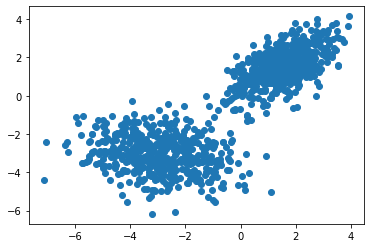

tensor([[-2.5388, -4.0384,  0.0000,  0.0000,  1.0000],
        [ 2.5144,  2.0649,  0.0000,  1.0000,  0.0000],
        [ 0.8635,  0.6303,  1.0000,  0.0000,  0.0000],
        ...,
        [-4.1341, -3.1110,  0.0000,  1.0000,  0.0000],
        [ 2.2555,  2.3592,  1.0000,  0.0000,  0.0000],
        [ 3.1069,  2.2907,  0.0000,  1.0000,  0.0000]])
tensor([1.4972, 1.5027, 0.6581, 0.2306, 0.1113])
tensor([-2.9382, -3.0421,  0.3018,  0.3883,  0.3099])


In [11]:
class ToyMixedDataset(Dataset):
    def __init__(self, num_samples=1000, pvals_y0=[.7, .2, .1],
                 pvals_y1=[.3, .4, .3],
                 y1_mixture_weight=0.5, mu0=None, mu1=None, sigma0=None, sigma1=None):
        
        if mu0 is None:
            mu0 = np.array([1.5,1.5])

        if mu1 is None:
            mu1 = np.array([-3,-3])

        if sigma0 is None:
            sigma0 = np.array([
                [1, .6],
                [.6, 1]
            ])

        if sigma1 is None:
            sigma1 = np.array([
                [2, -.3],
                [-.3, 1]
            ])

        y = np.random.binomial(1, y1_mixture_weight, size=(num_samples, 1))
        self.y = y

        samples_real = np.zeros((num_samples, 2))
        samples_cat = np.zeros((num_samples, 3))

        samples_y0 = np.random.multivariate_normal(mu0, sigma0, size=num_samples)
        samples_y1 = np.random.multivariate_normal(mu1, sigma1, size=num_samples)

        samples_real[y.flatten() == 0, :] = samples_y0[y.flatten() == 0, :]
        samples_real[y.flatten() == 1, :] = samples_y1[y.flatten() == 1, :]
        
        samples_cat_y0 = np.random.multinomial(1, pvals=pvals_y0, size=num_samples)
        samples_cat_y1 = np.random.multinomial(1, pvals=pvals_y1, size=num_samples)
        
        samples_cat[y.flatten() == 0, :] = samples_cat_y0[y.flatten() == 0, :]
        samples_cat[y.flatten() == 1, :] = samples_cat_y1[y.flatten() == 1, :]
        
        samples = np.concatenate((samples_real, samples_cat), axis=1)

        self.data = torch.from_numpy(samples.astype('float32'))
        self.targets = torch.from_numpy(y.flatten().astype('int32'))
            

    def __getitem__(self, index):
  
        return self.data[index], self.targets[index]
        
        
    def __len__(self):
        return len(self.data)
    
    
dataset = ToyMixedDataset(num_samples=1000)
    


fig, ax = plt.subplots()

ax.scatter(dataset.data.numpy()[:, 0].flatten(),
        dataset.data.numpy()[:, 1].flatten()
       )

plt.show()
plt.close()

print(dataset.data)
print(dataset.data[dataset.targets.flatten() == 0].mean(axis=0))
print(dataset.data[dataset.targets.flatten() == 1].mean(axis=0))

Epoch 3:   0%|          | 2/1000 [00:00<01:27, 11.45it/s, avg_loss=2.39e+3, avg_y_max=0.615, avg_y_min=0.385, cond_entropy_y_z=-65.6, kl_wxy_wy=16.2, kl_zx_z=82.3, post_y_approx=5.61, reconstruction_error=2.35e+3, val_avg_loss=2.33e+3, val_avg_y_max=0.612, val_avg_y_min=0.388, val_cond_entropy_y_z=-65.7, val_kl_wxy_wy=16.1, val_kl_zx_z=83.1, val_post_y_approx=5.63, val_reconstruction_error=2.29e+3]

x_dim: 5
y_dim: 2
z_dim: 3
w_dim: 1
beta1: 5
beta2: 15
beta3: 10
beta4: 100
beta5: 10
p_y1: 0.494
p_y0: 0.506


Epoch 1000: 100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s, avg_loss=-9.86, avg_y_max=0.533, avg_y_min=0.467, cond_entropy_y_z=-68.9, kl_wxy_wy=28.4, kl_zx_z=18.7, post_y_approx=6.9, reconstruction_error=5.16, val_avg_loss=-9.59, val_avg_y_max=0.534, val_avg_y_min=0.466, val_cond_entropy_y_z=-68.9, val_kl_wxy_wy=28.3, val_kl_zx_z=19.4, val_post_y_approx=6.95, val_reconstruction_error=4.6]      


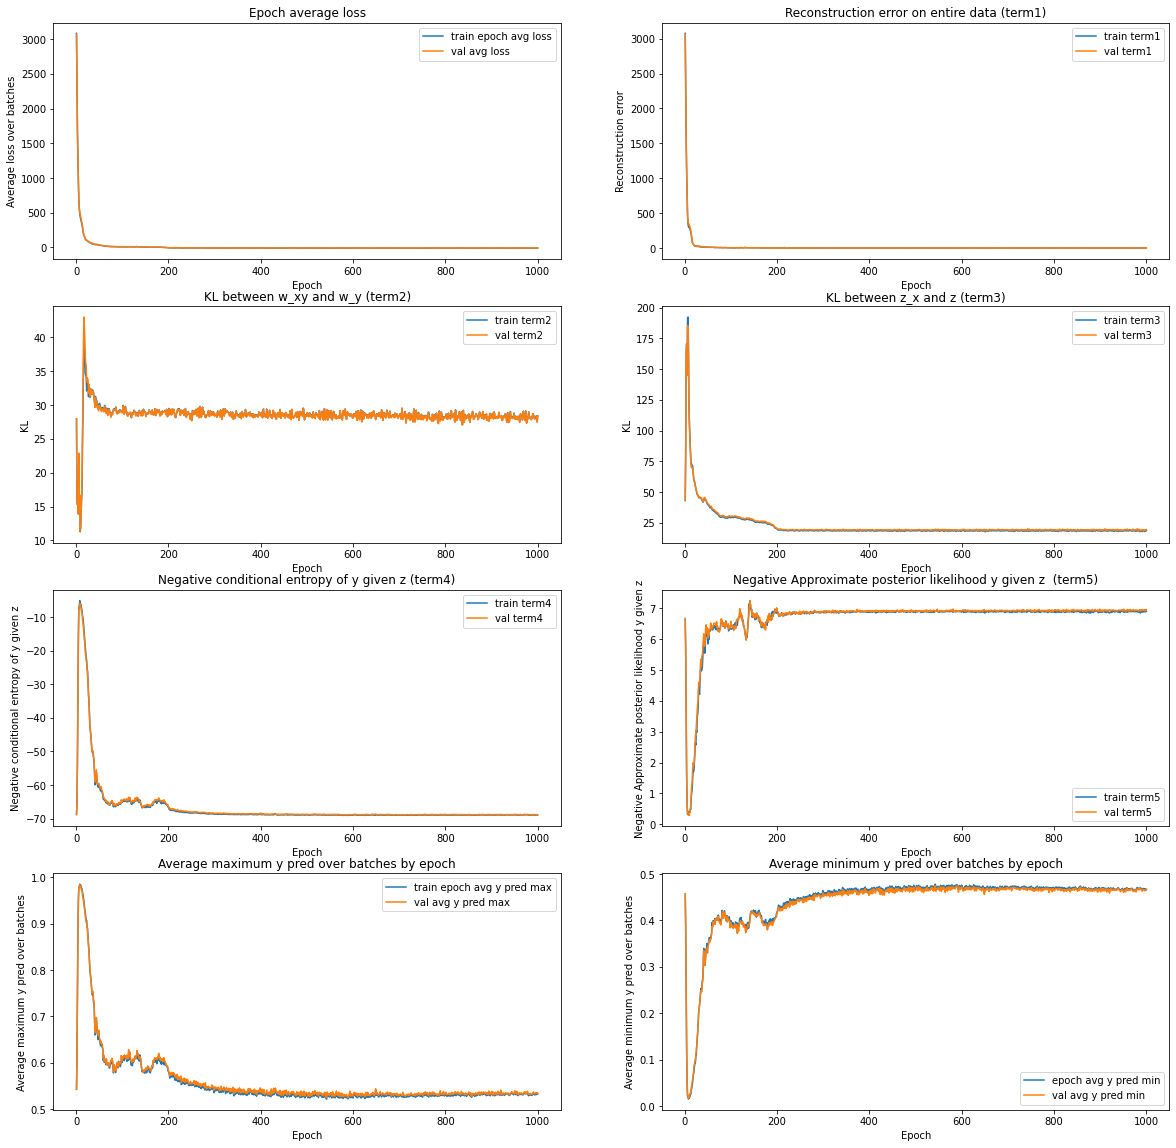

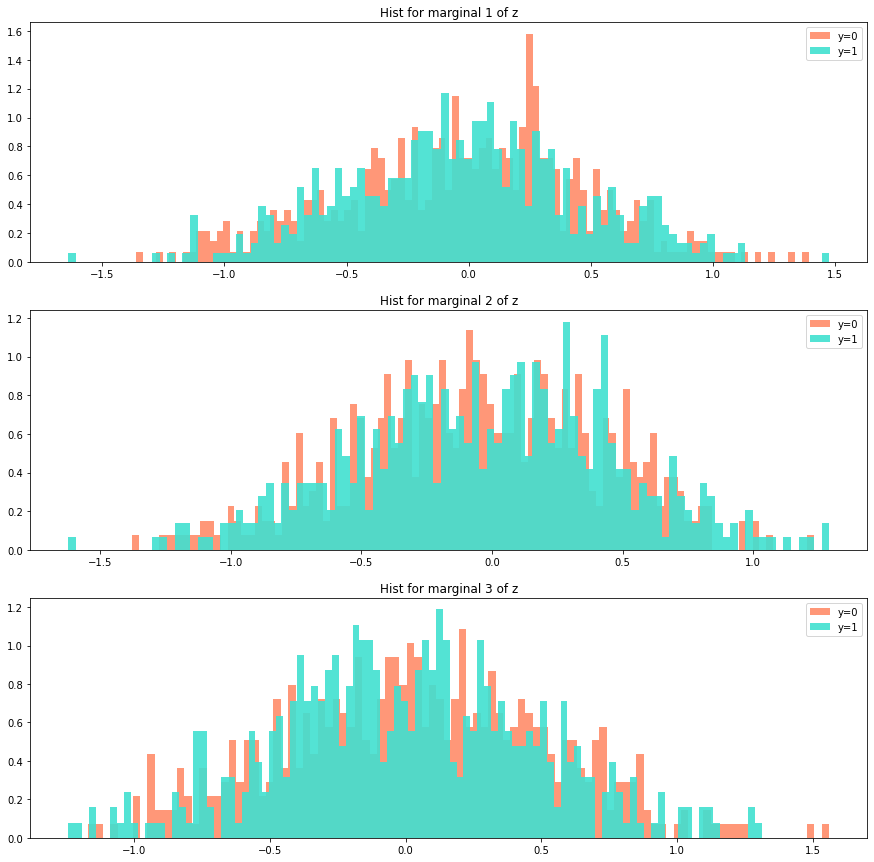

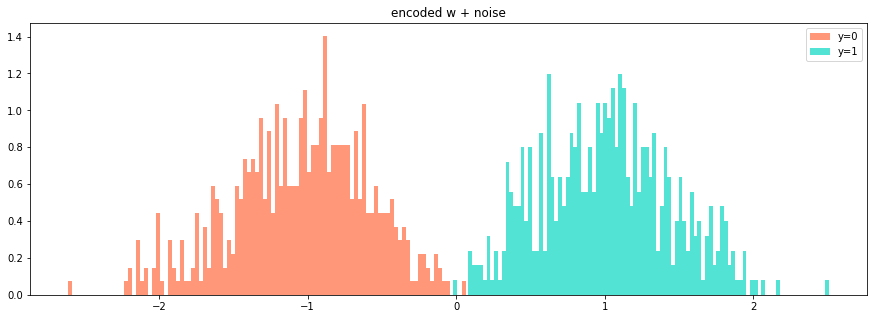

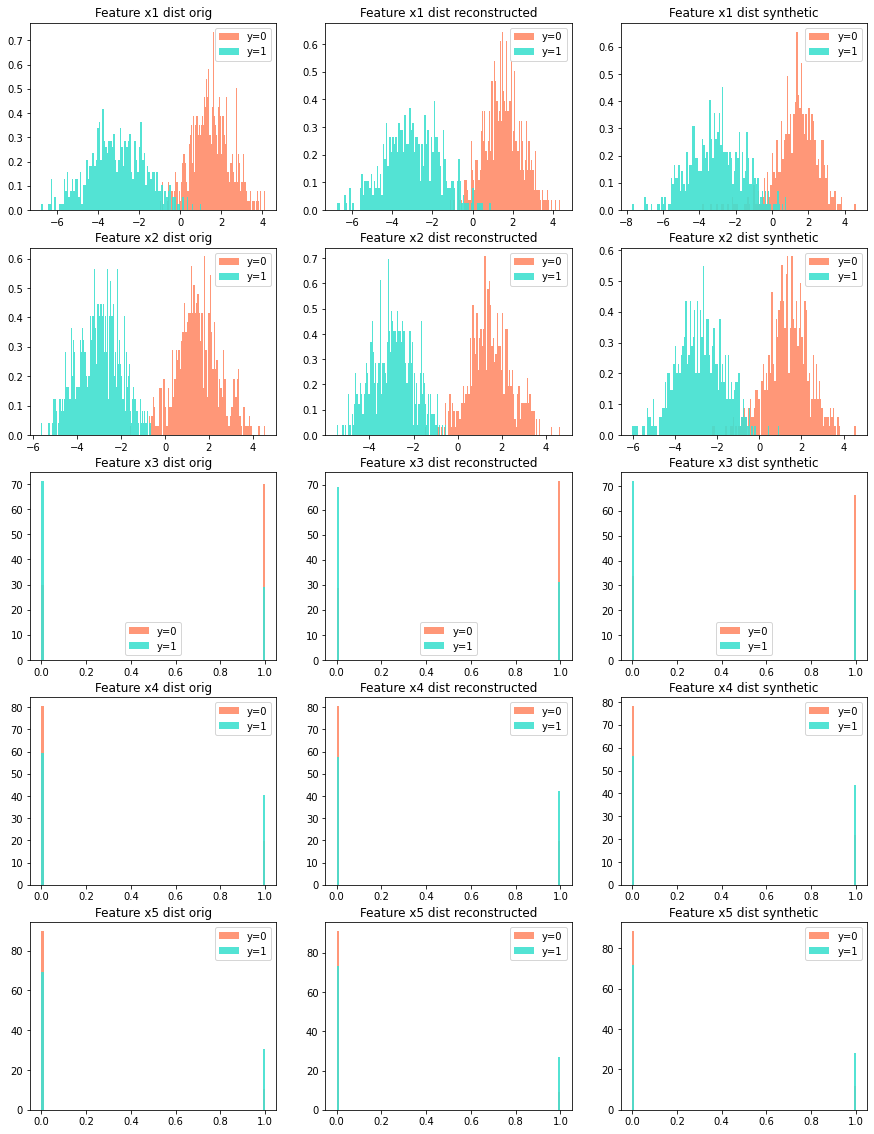

original correlations
          0         1         2         3         4
0  1.000000  0.841744  0.390310 -0.228133 -0.225515
1  0.841744  1.000000  0.360014 -0.204654 -0.214579
2  0.390310  0.360014  1.000000 -0.650488 -0.502669
3 -0.228133 -0.204654 -0.650488  1.000000 -0.329606
4 -0.225515 -0.214579 -0.502669 -0.329606  1.000000
reconstructed correlations
          0         1         2         3         4
0  1.000000  0.840850  0.396508 -0.244172 -0.223391
1  0.840850  1.000000  0.367493 -0.216532 -0.218839
2  0.396508  0.367493  1.000000 -0.686097 -0.478561
3 -0.244172 -0.216532 -0.686097  1.000000 -0.310453
4 -0.223391 -0.218839 -0.478561 -0.310453  1.000000
synthetic correlations
          0         1         2         3         4
0  1.000000  0.810858  0.405256 -0.252269 -0.210707
1  0.810858  1.000000  0.353646 -0.222548 -0.181049
2  0.405256  0.353646  1.000000 -0.661525 -0.474108
3 -0.252269 -0.222548 -0.661525  1.000000 -0.346648
4 -0.210707 -0.181049 -0.474108 -0.346648  1

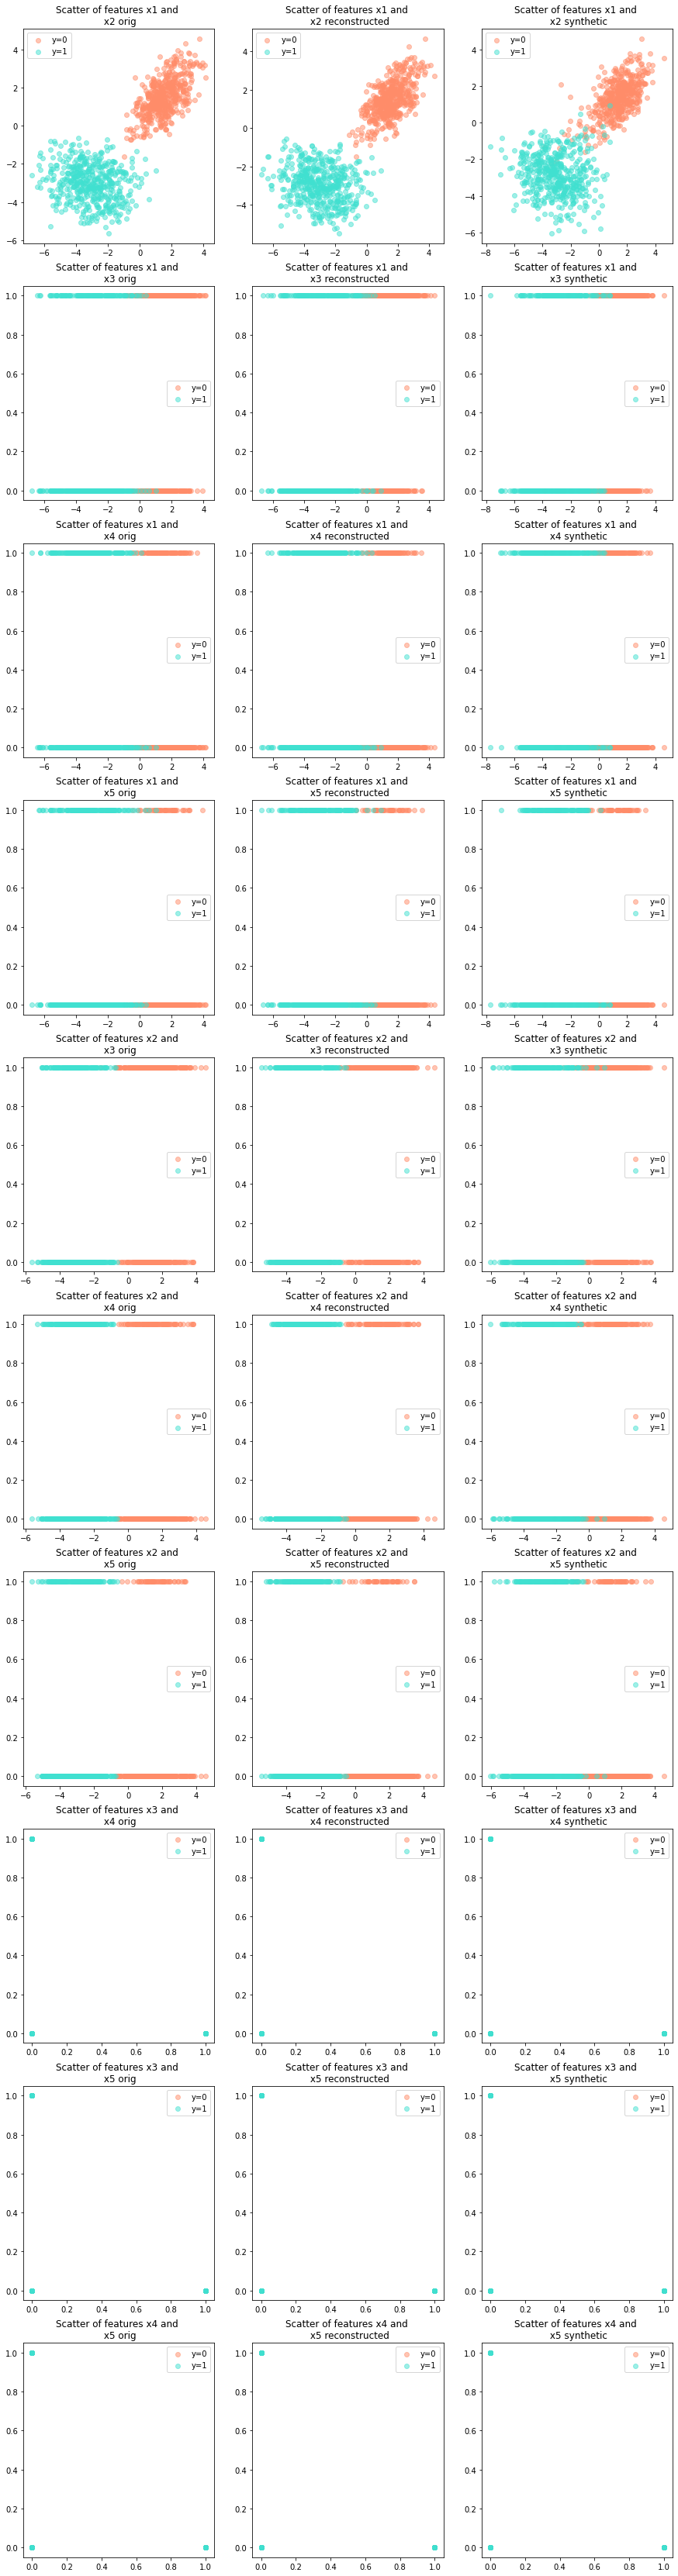

[[1. 0.]]


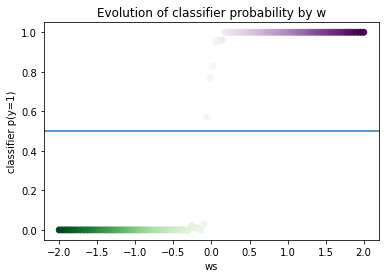

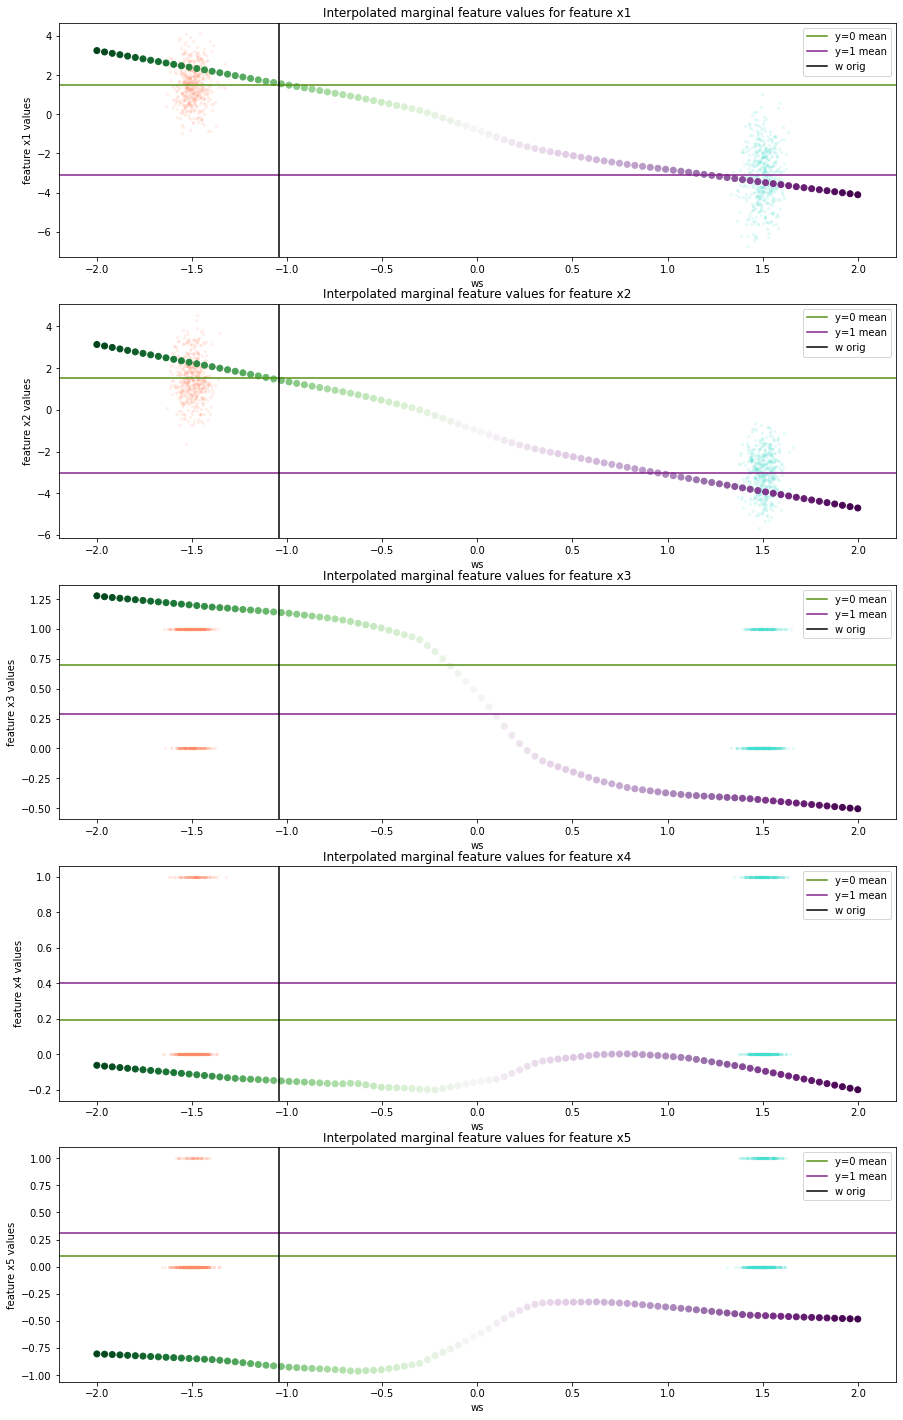

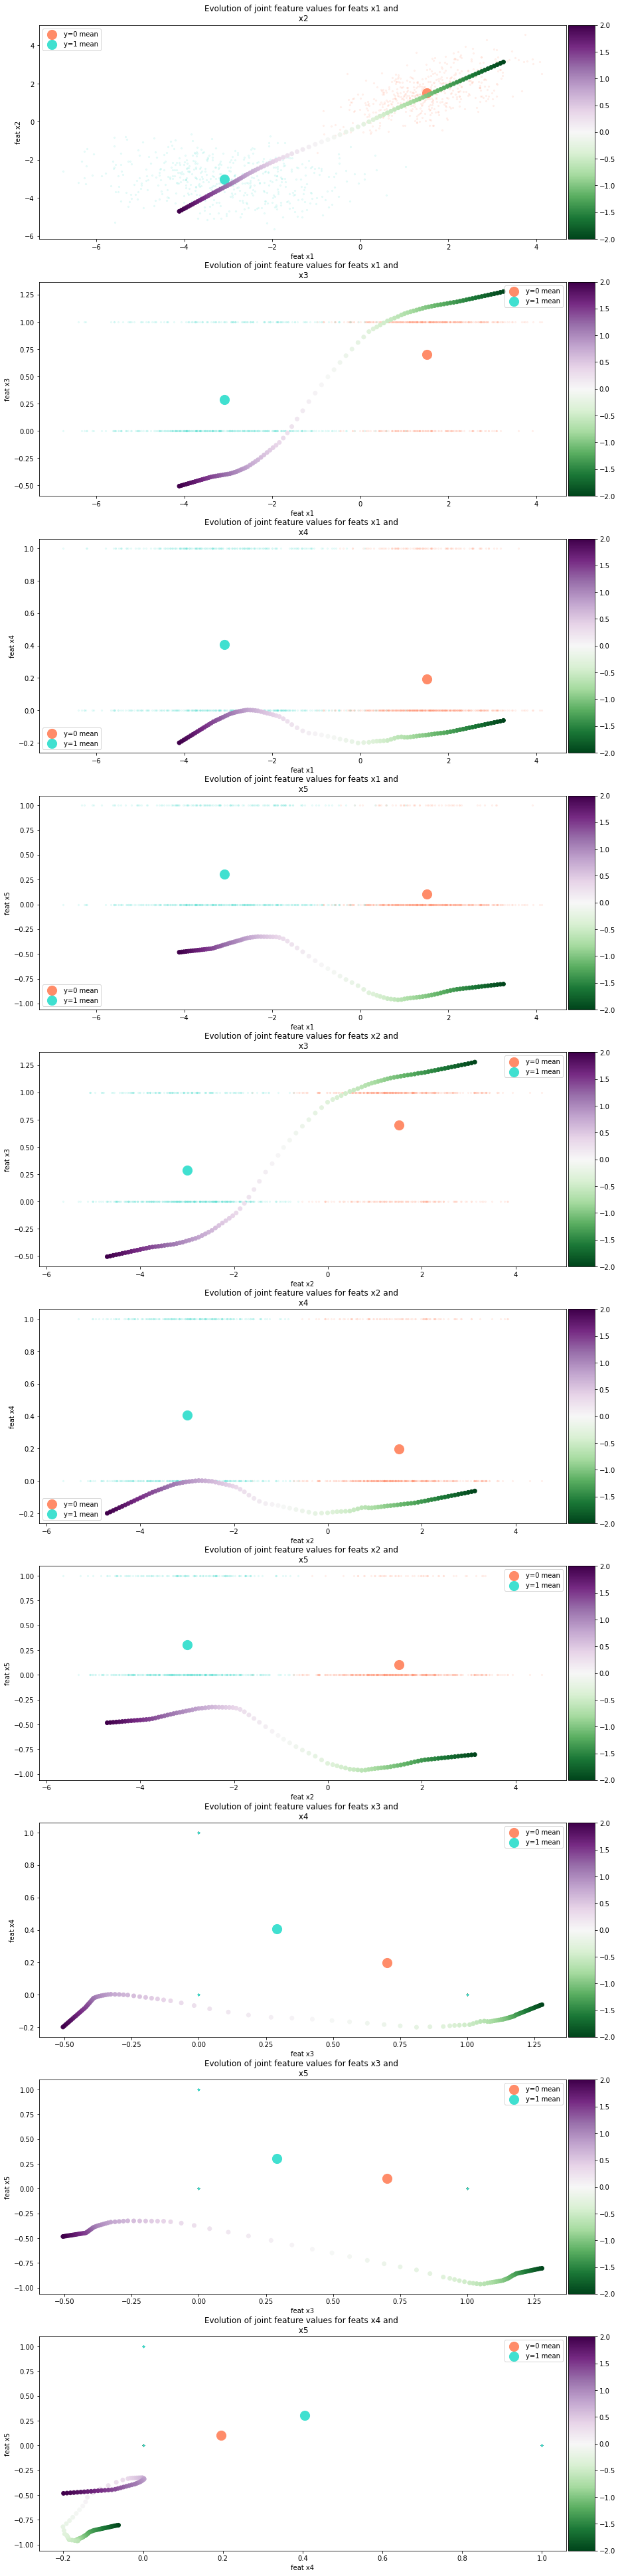

In [14]:
 likelihood_partition = {
                (0, 1): 'real',
                (2, 4): 'categorical'
            }
    
    
train_dataset = ToyMixedDataset(num_samples=1000)
val_dataset = ToyMixedDataset(num_samples=1000)


likelihood_params = {'lik_var' : 0.1**2, 'lik_var_lognormal': 0.1**2}

csvae = CSVAE(x_dim=train_dataset.data.shape[1], 
              y_dim=2, 
              z_dim=3, 
              w_dim=1, 
              z_prior_var=CSVAE_Z_PRIOR_VAR,
              likelihood_partition=likelihood_partition,
              likelihood_params=likelihood_params,
              beta1=CSVAE_BETA1, 
              beta2=CSVAE_BETA2, 
              beta3=CSVAE_BETA3, 
              beta4=CSVAE_BETA4,
              beta5=CSVAE_BETA5
             )


csvae.set_train_dataset(train_dataset, featnames=['x1', 'x2', 'x3', 'x4', 'x5'])
csvae.set_val_dataset(val_dataset)
csvae.train(num_epochs=CSVAE_NUM_EPOCHS)

plot_history_csvae(csvae)
debug_nd_csvae(csvae)
#debug_nd_csvae(csvae, experiment_instance_output_dir, use_val=True)

# see effect of changing class
x_y0_exemplar = torch.from_numpy(csvae.train_X_numpy[csvae.train_y_numpy == 0].mean(axis=0).reshape(1, -1).astype('float32'))
x_y0_exemplar_numpy = x_y0_exemplar.detach().numpy()

X_train = csvae.train_X_numpy
y_train = csvae.train_y_numpy

rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=None,
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0,
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None, 
                            ccp_alpha=0.0, 
                            max_samples=None)
rf.fit(X_train, y_train)

print(rf.predict_proba(x_y0_exemplar_numpy))

debug_class_change_csvae(csvae, x_y0_exemplar, np.array([0.]), w_range=None, clf=rf)

In [17]:
samples = csvae.unconditional_sample(S=1000, y=csvae.train_y)

print(samples[csvae.train_y.flatten() == 0].mean(axis=0))
print(samples[csvae.train_y.flatten() == 1].mean(axis=0))




tensor([1.4184, 1.4584, 0.6680, 0.1996, 0.1324])
tensor([-2.8993, -2.8761,  0.2935,  0.4109,  0.2955])


In [40]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

## 7 Data Types Example <a class="anchor" id="example2"></a>

In [116]:
class Toy7Dataset(Dataset):
    def __init__(self, num_samples=1000):
        
        # sample ys
        y = np.random.binomial(1, 0.5, size=(num_samples, 1))
        self.y = y
        
        samples_bin = np.zeros((num_samples, 1))
        samples_cat = np.zeros((num_samples, 3))
        samples_ord = np.zeros((num_samples, 3))
        samples_ucount = np.zeros((num_samples, 1))
        samples_count = np.zeros((num_samples, 1))
        samples_posreal = np.zeros((num_samples, 1))
        samples_real = np.zeros((num_samples, 1))
        
        # binary
        samples_bin_y0 = np.random.binomial(1, 0.3, size=(num_samples, 1))
        samples_bin_y1 = np.random.binomial(1, 0.7, size=(num_samples, 1))
        
        samples_bin[y.flatten() == 0, :] = samples_bin_y0[y.flatten() == 0, :]
        samples_bin[y.flatten() == 1, :] = samples_bin_y1[y.flatten() == 1, :]
        
        # categorical
        samples_cat_y0 = np.random.multinomial(1, [.7, .2, .1], size=num_samples)
        samples_cat_y1 = np.random.multinomial(1, [.3, .4, .3], size=num_samples)
        
        samples_cat[y.flatten() == 0, :] = samples_cat_y0[y.flatten() == 0, :]
        samples_cat[y.flatten() == 1, :] = samples_cat_y1[y.flatten() == 1, :]
        
        # ordinal
        samples_ord_y0 = np.random.multinomial(1, [.1, .1, .8], size=num_samples)
        samples_ord_y1 = np.random.multinomial(1, [.4, .4, .2], size=num_samples)
        
        samples_ord[y.flatten() == 0, :] = samples_ord_y0[y.flatten() == 0, :]
        samples_ord[y.flatten() == 1, :] = samples_ord_y1[y.flatten() == 1, :]
        
        # unbounded count
        samples_ucount_y0 = np.random.binomial(20, 0.3, size=(num_samples, 1))
        samples_ucount_y1 = np.random.binomial(20, 0.7, size=(num_samples, 1))
        
        samples_ucount[y.flatten() == 0, :] = samples_ucount_y0[y.flatten() == 0, :]
        samples_ucount[y.flatten() == 1, :] = samples_ucount_y1[y.flatten() == 1, :]
        
        # count
        samples_count_y0 = np.random.poisson(lam=5, size=(num_samples, 1))
        samples_count_y1 = np.random.poisson(lam=10, size=(num_samples, 1))
        
        samples_count[y.flatten() == 0, :] = samples_count_y0[y.flatten() == 0, :]
        samples_count[y.flatten() == 1, :] = samples_count_y1[y.flatten() == 1, :]
        
        # positive real
        samples_posreal_y0 = np.exp(np.random.normal(loc=-1, scale=0.5, size=(num_samples, 1)))
        samples_posreal_y1 = np.exp(np.random.normal(loc=1, scale=0.5, size=(num_samples, 1)))
        
        samples_posreal[y.flatten() == 0, :] = samples_posreal_y0[y.flatten() == 0, :]
        samples_posreal[y.flatten() == 1, :] = samples_posreal_y1[y.flatten() == 1, :]
        
        # real
        samples_real_y0 = np.random.normal(loc=-1, scale=1, size=(num_samples, 1))
        samples_real_y1 = np.random.normal(loc=1, scale=1, size=(num_samples, 1))
        
        samples_real[y.flatten() == 0, :] = samples_real_y0[y.flatten() == 0, :]
        samples_real[y.flatten() == 1, :] = samples_real_y1[y.flatten() == 1, :]
        


        
        samples = np.concatenate((samples_bin, 
                                    samples_cat,
                                    samples_ord,
                                    samples_ucount,
                                    samples_count,
                                    samples_posreal,
                                    samples_real
                                  ),
                                  axis=1)

        self.data = torch.from_numpy(samples.astype('float32'))
        self.targets = torch.from_numpy(y.flatten().astype('int32'))
            

    def __getitem__(self, index):
  
        return self.data[index], self.targets[index]
        
        
    def __len__(self):
        return len(self.data)
    
    
dataset = Toy7Dataset(num_samples=1000)
    

print(dataset.data[dataset.targets.flatten() == 0].mean(axis=0))
print(dataset.data[dataset.targets.flatten() == 1].mean(axis=0))

tensor([[ 0.0000,  1.0000,  0.0000,  ...,  7.0000,  0.3222, -3.6800],
        [ 0.0000,  0.0000,  1.0000,  ...,  7.0000,  2.7072, -0.5775],
        [ 0.0000,  1.0000,  0.0000,  ...,  7.0000,  0.4410, -2.2048],
        ...,
        [ 1.0000,  0.0000,  1.0000,  ...,  8.0000,  2.1845, -0.9237],
        [ 1.0000,  1.0000,  0.0000,  ...,  7.0000,  0.5519, -0.0442],
        [ 0.0000,  1.0000,  0.0000,  ...,  4.0000,  0.2195, -1.9536]])
tensor([ 0.3101,  0.6899,  0.1910,  0.1191,  0.1068,  0.0986,  0.7947,  6.0575,
         4.9877,  0.4183, -0.9801])
tensor([ 0.6862,  0.2846,  0.4347,  0.2807,  0.4269,  0.3743,  0.1988, 13.9864,
        10.2027,  3.1079,  1.0597])


Epoch 2:   0%|          | 1/1000 [00:00<01:51,  8.94it/s, avg_loss=857, avg_y_max=0.539, avg_y_min=0.461, cond_entropy_y_z=-68.9, kl_wxy_wy=32.1, kl_zx_z=34, post_y_approx=6.74, reconstruction_error=853, val_avg_loss=895, val_avg_y_max=0.539, val_avg_y_min=0.461, val_cond_entropy_y_z=-68.9, val_kl_wxy_wy=32.8, val_kl_zx_z=34.2, val_post_y_approx=6.82, val_reconstruction_error=890]

x_dim: 11
y_dim: 2
z_dim: 7
w_dim: 1
beta1: 5
beta2: 15
beta3: 10
beta4: 100
beta5: 10
p_y1: 0.514
p_y0: 0.486


Epoch 1000: 100%|██████████| 1000/1000 [01:50<00:00,  9.08it/s, avg_loss=11.9, avg_y_max=0.599, avg_y_min=0.401, cond_entropy_y_z=-66.4, kl_wxy_wy=16.5, kl_zx_z=20.9, post_y_approx=6.67, reconstruction_error=34.2, val_avg_loss=12.3, val_avg_y_max=0.596, val_avg_y_min=0.404, val_cond_entropy_y_z=-66.5, val_kl_wxy_wy=16.6, val_kl_zx_z=20.8, val_post_y_approx=6.47, val_reconstruction_error=35]


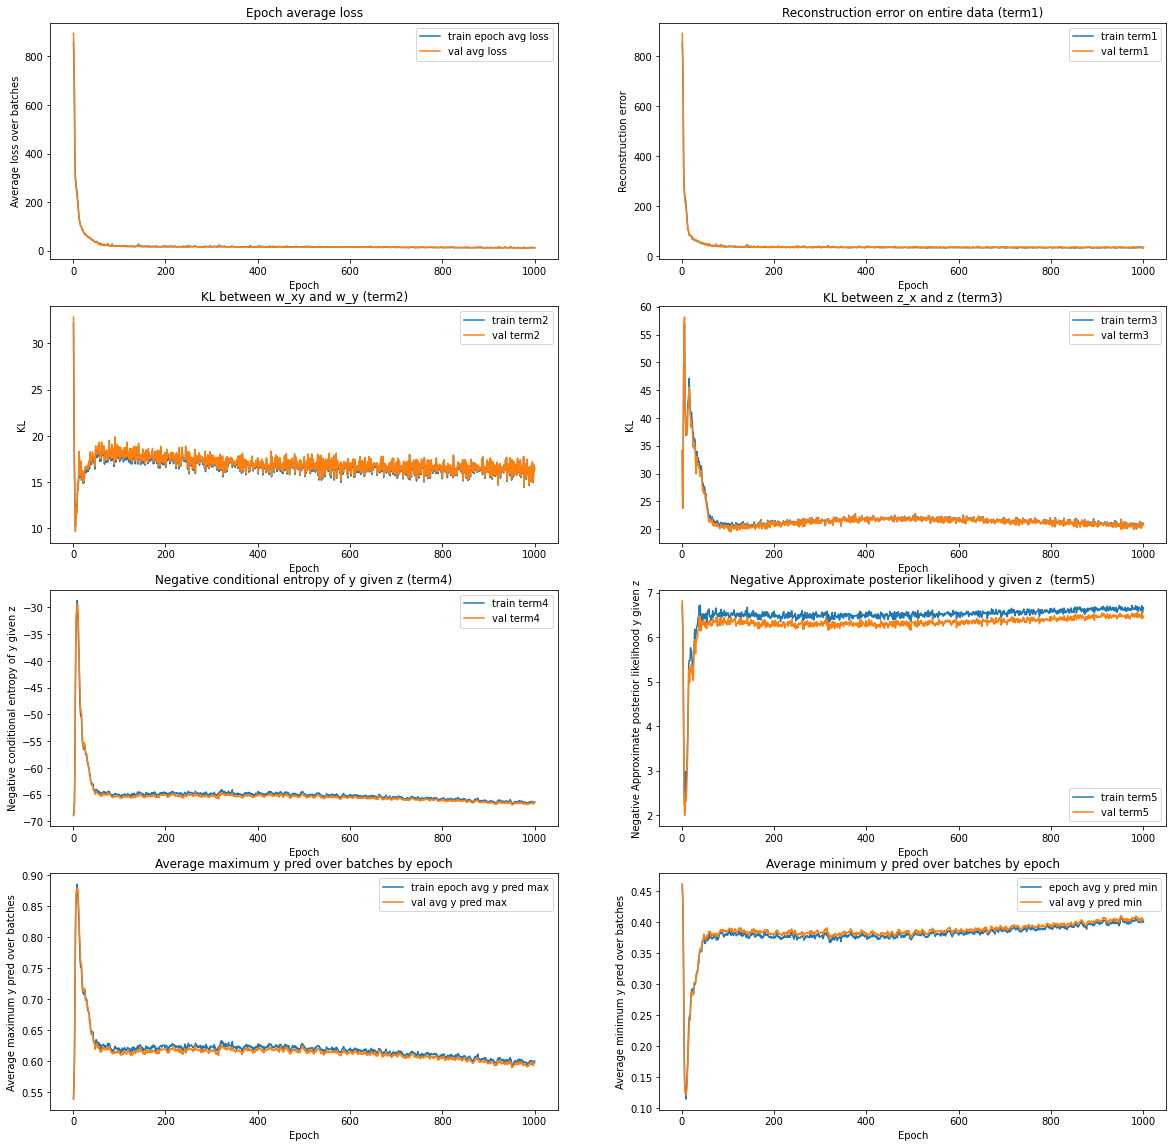

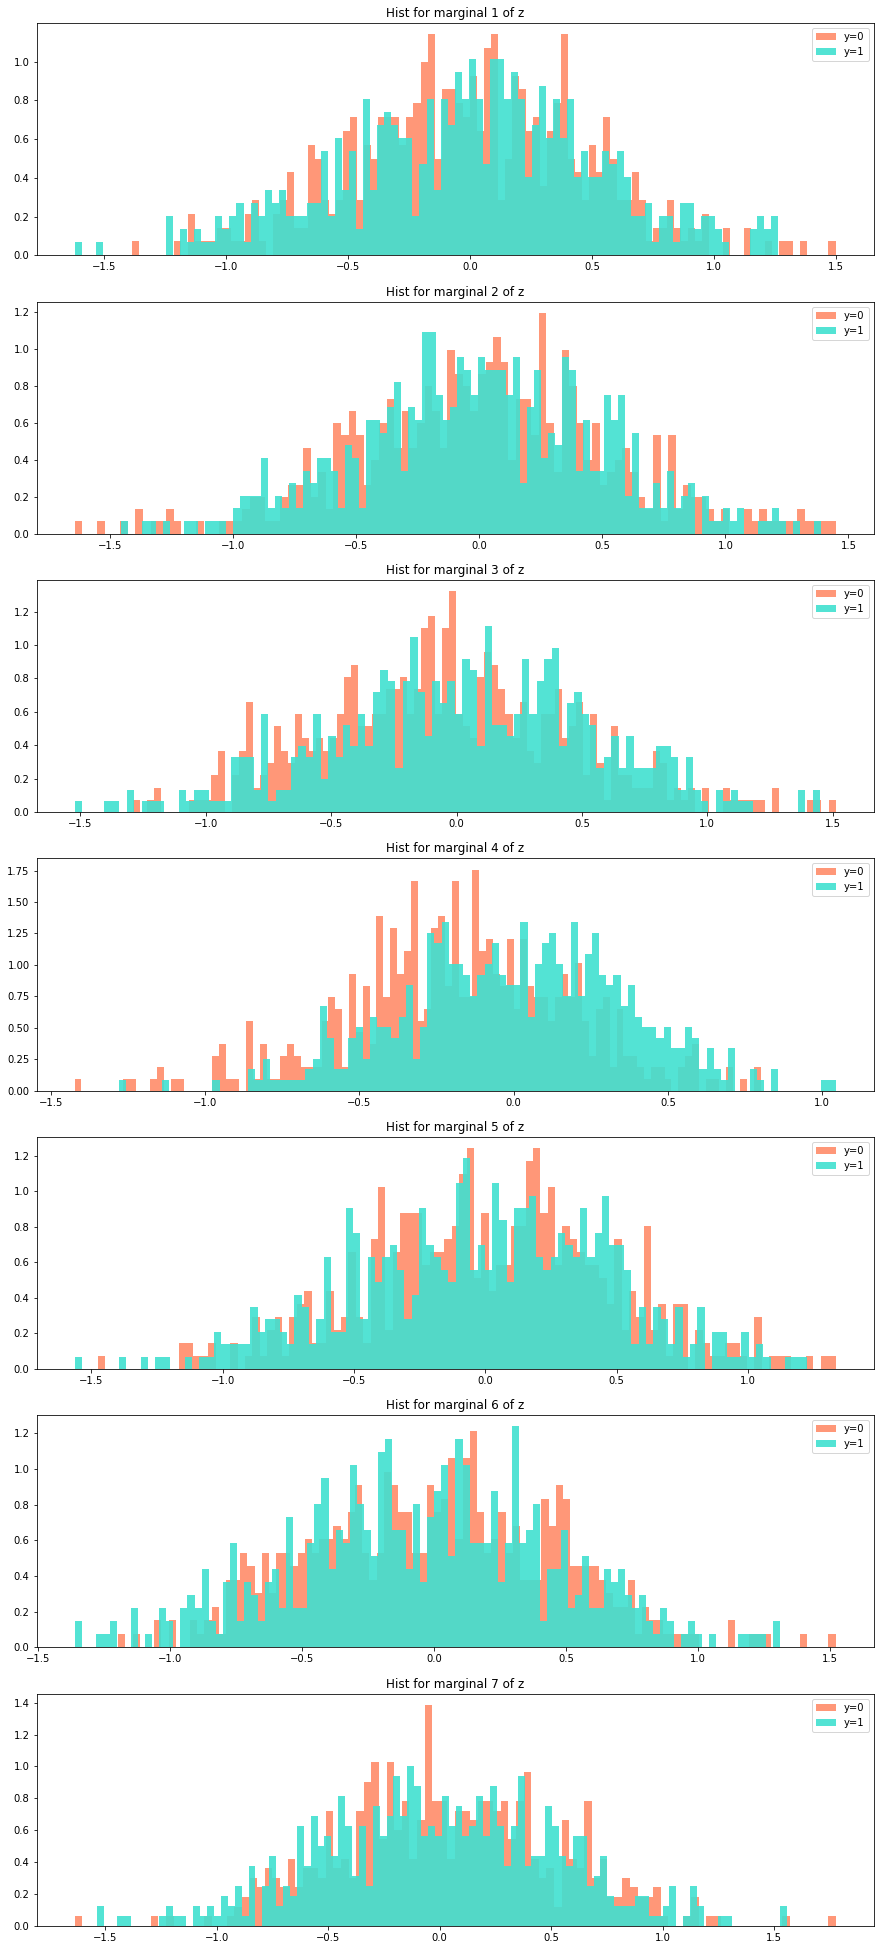

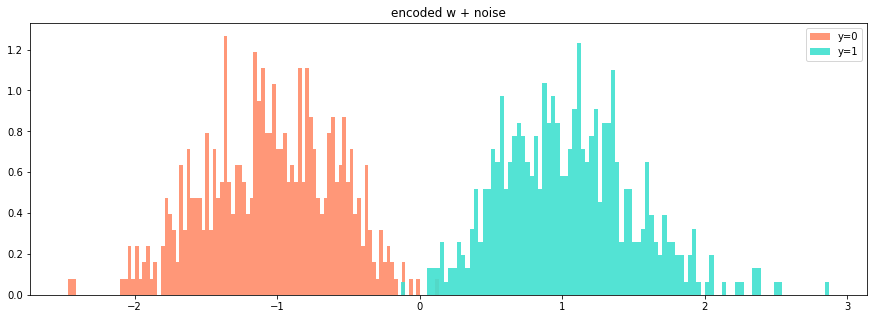

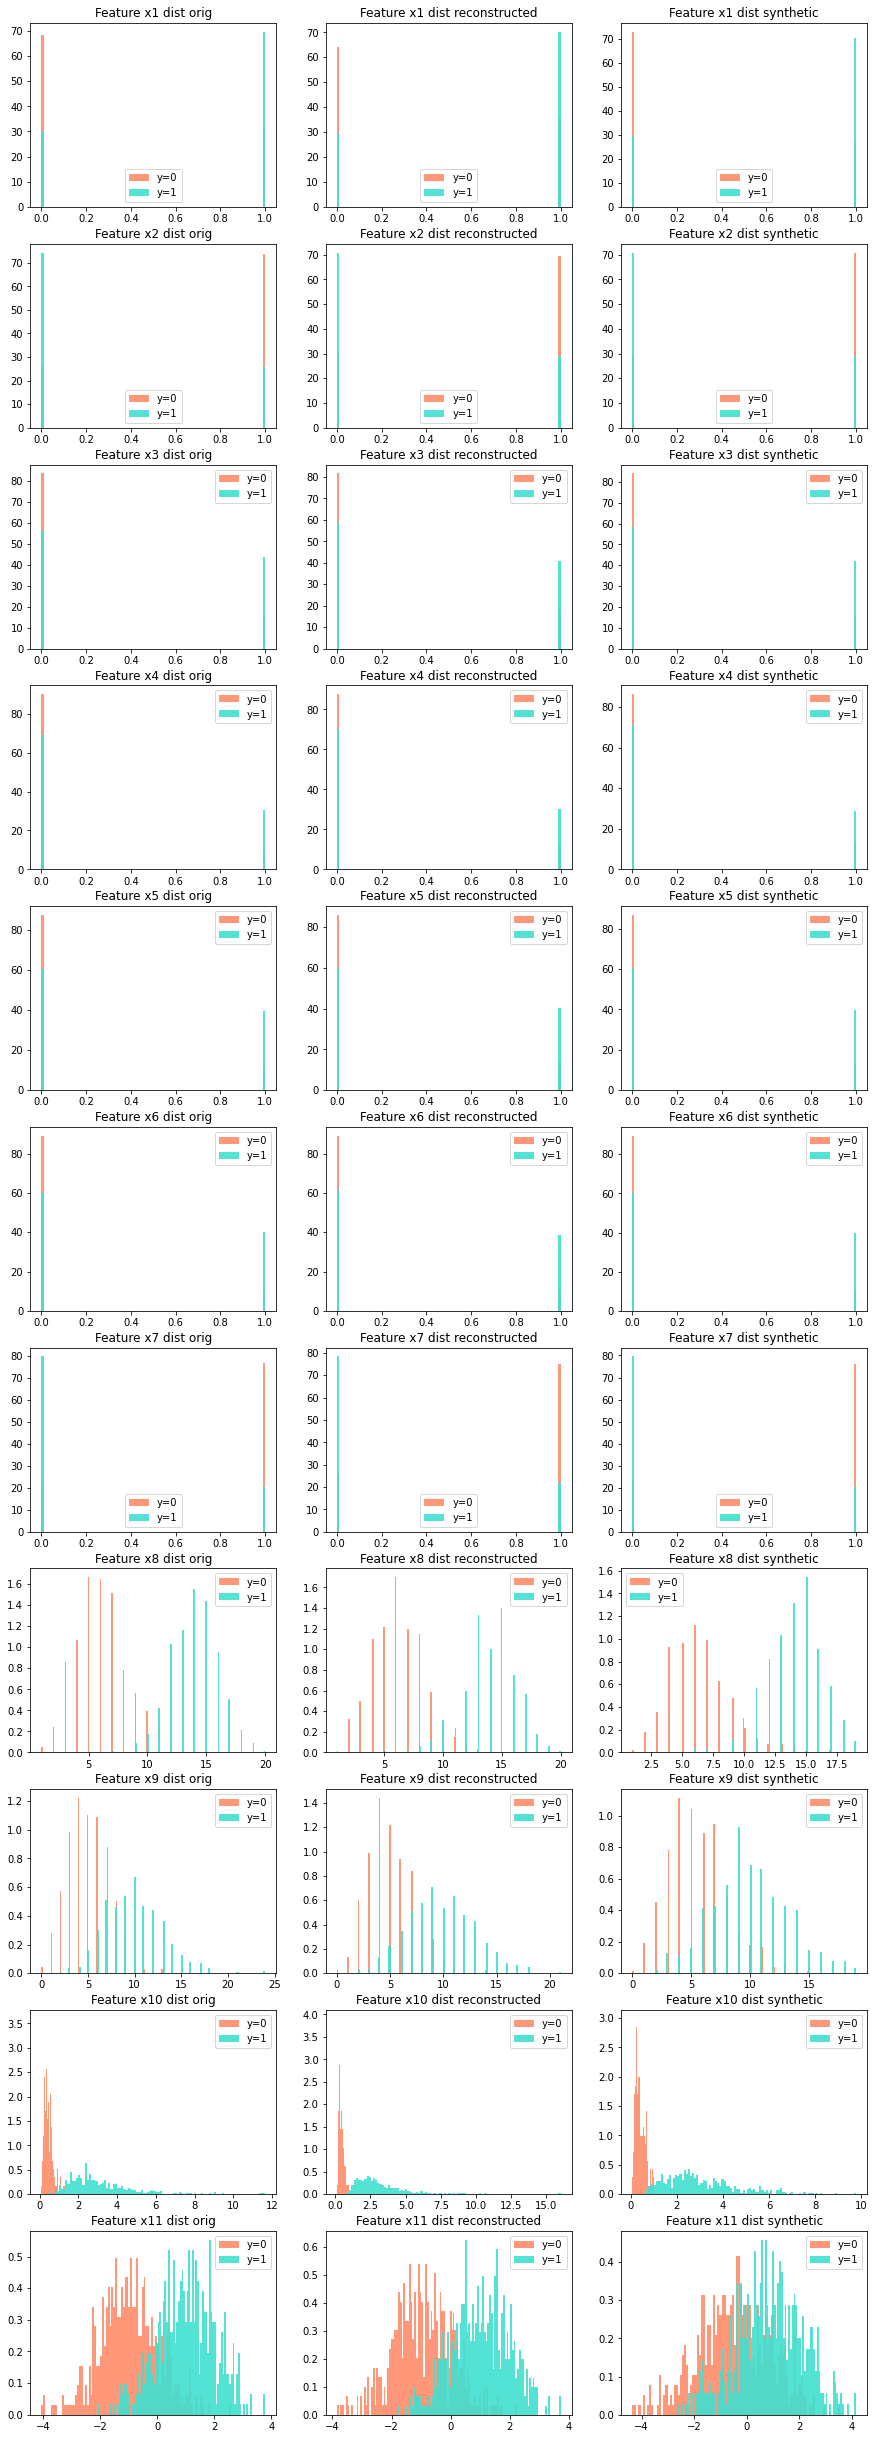

original correlations
          0         1         2         3         4         5         6   \
0   1.000000 -0.191681  0.113907  0.107506  0.125442  0.137460 -0.231289   
1  -0.191681  1.000000 -0.647570 -0.500271 -0.127822 -0.144381  0.239464   
2   0.113907 -0.647570  1.000000 -0.335837  0.065790  0.105270 -0.150439   
3   0.107506 -0.500271 -0.335837  1.000000  0.083244  0.058851 -0.125059   
4   0.125442 -0.127822  0.065790  0.083244  1.000000 -0.354091 -0.570496   
5   0.137460 -0.144381  0.105270  0.058851 -0.354091  1.000000 -0.566082   
6  -0.231289  0.239464 -0.150439 -0.125059 -0.570496 -0.566082  1.000000   
7   0.355102 -0.426371  0.256734  0.235312  0.263006  0.293430 -0.489518   
8   0.244533 -0.322665  0.202704  0.168515  0.209370  0.208143 -0.367342   
9   0.259065 -0.354703  0.199085  0.212230  0.202212  0.236628 -0.386048   
10  0.189903 -0.353229  0.201743  0.207388  0.240944  0.195208 -0.383814   

          7         8         9         10  
0   0.355102  0.2445

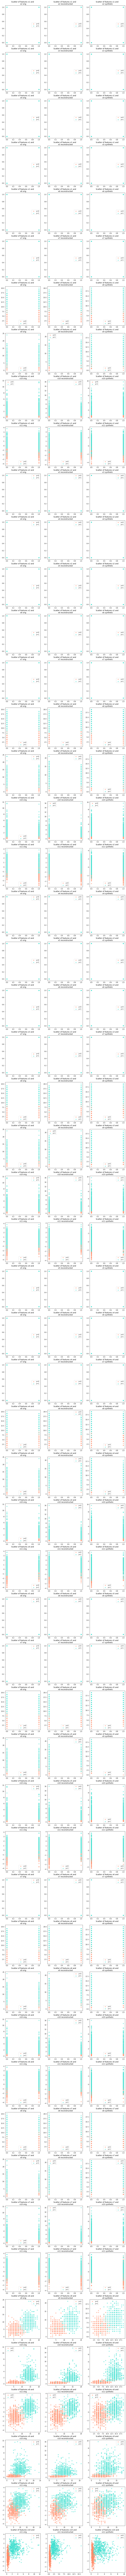

[[1. 0.]]


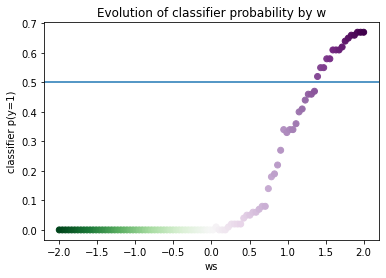

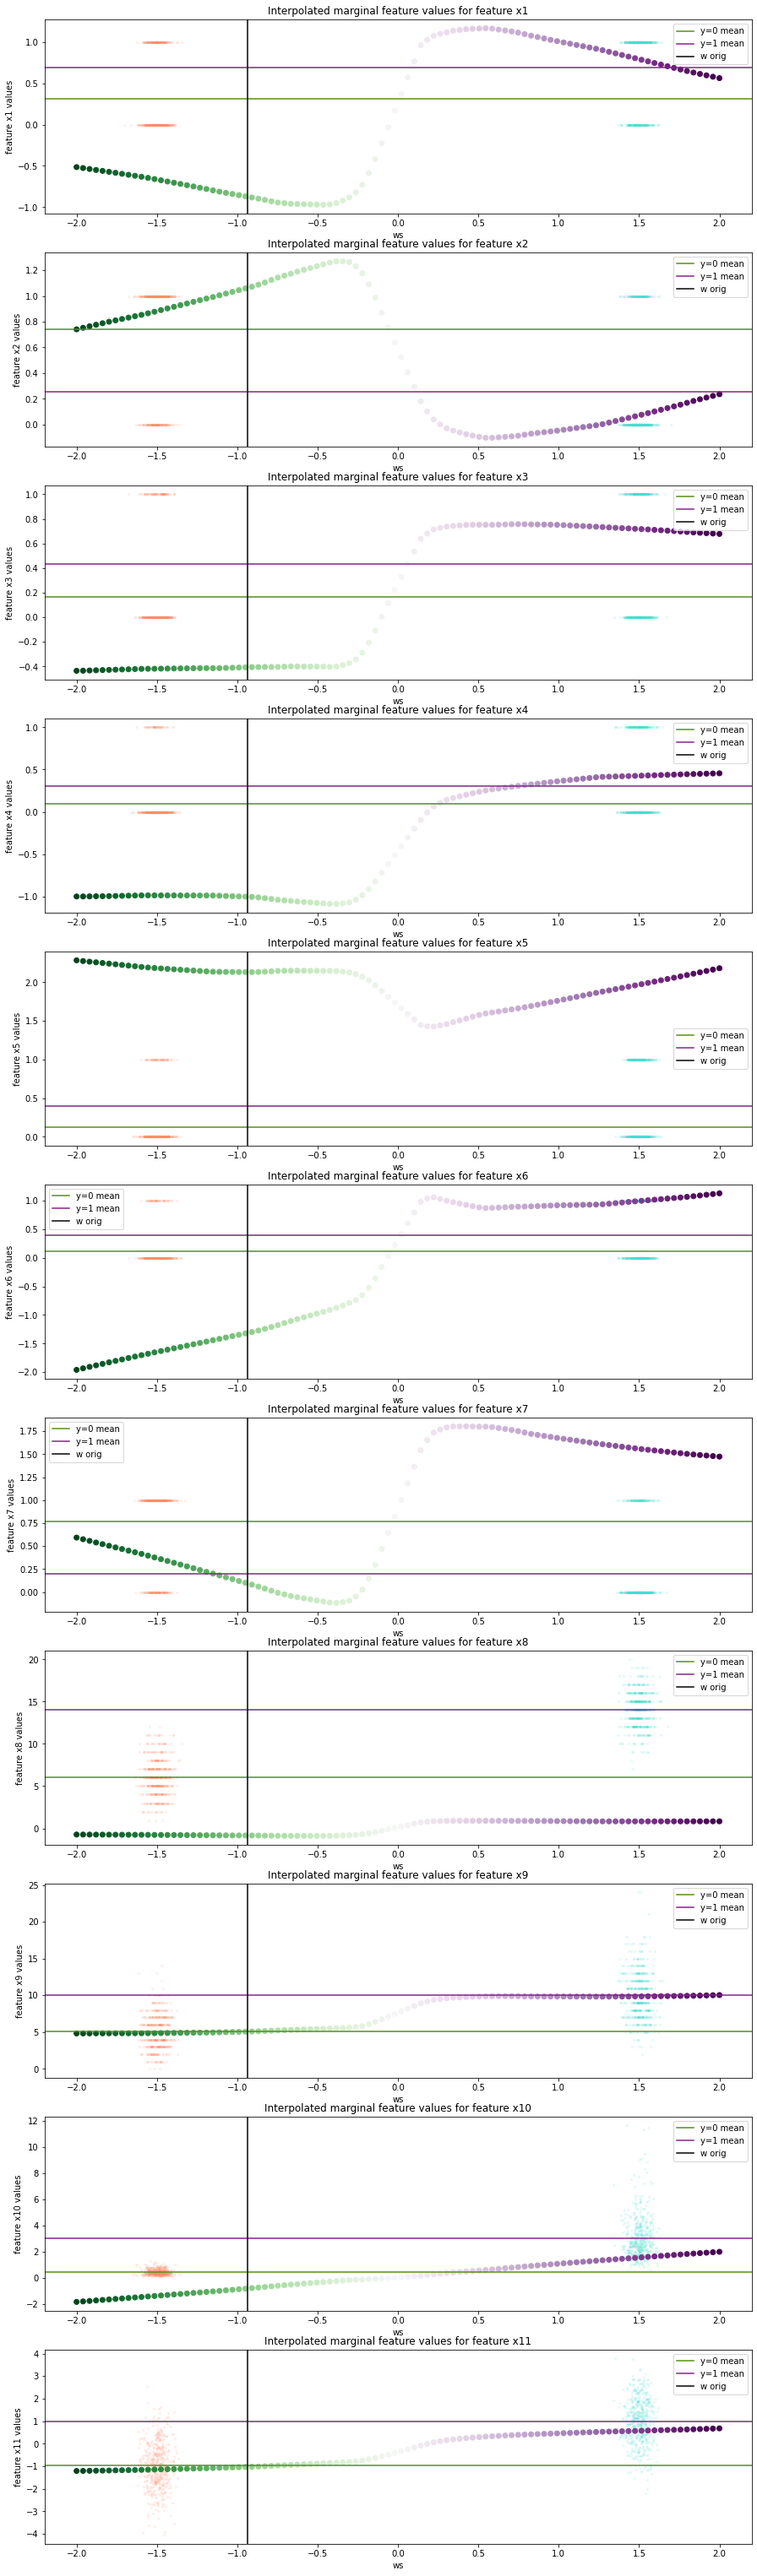

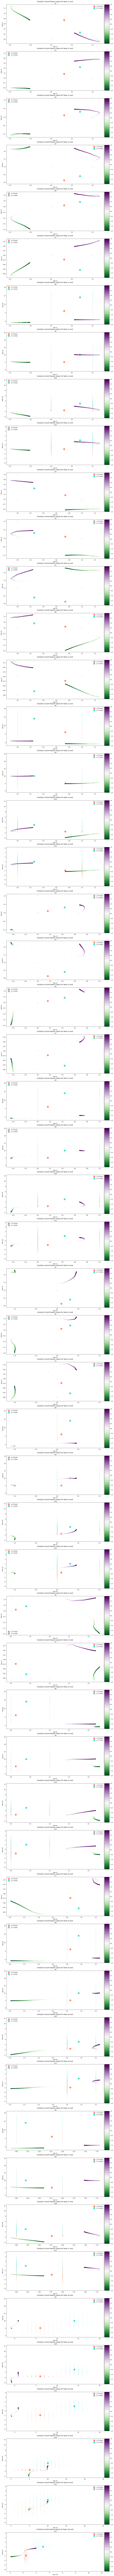

In [117]:
 likelihood_partition = {
                (0, 0): 'binary',
                (1, 3): 'categorical',
                 (4, 6): 'ordinal',
                 (7, 7): 'binomial',
                 (8, 8): 'count',
                 (9, 9): 'positive',
                 (10, 10): 'real'
            }
    
train_dataset = Toy7Dataset(num_samples=1000)
val_dataset = Toy7Dataset(num_samples=1000)

likelihood_params = {'lik_var' : 0.1**2, 'lik_var_lognormal': 0.1**2, 'binomial_num_trials': 20}

csvae = CSVAE(x_dim=train_dataset.data.shape[1], 
              y_dim=2, 
              z_dim=7, 
              w_dim=1, 
              z_prior_var=CSVAE_Z_PRIOR_VAR,
              likelihood_partition=likelihood_partition,
              likelihood_params=likelihood_params,
              beta1=CSVAE_BETA1, 
              beta2=CSVAE_BETA2, 
              beta3=CSVAE_BETA3, 
              beta4=CSVAE_BETA4,
              beta5=CSVAE_BETA5
             )


csvae.set_train_dataset(train_dataset, featnames=[f"x{i}" for i in range(1, 1+train_dataset.data.shape[1])])
csvae.set_val_dataset(val_dataset)
csvae.train(num_epochs=CSVAE_NUM_EPOCHS)

plot_history_csvae(csvae)
debug_nd_csvae(csvae)
#debug_nd_csvae(csvae, experiment_instance_output_dir, use_val=True)

# see effect of changing class
x_y0_exemplar = torch.from_numpy(csvae.train_X_numpy[csvae.train_y_numpy == 0].mean(axis=0).reshape(1, -1).astype('float32'))
x_y0_exemplar_numpy = x_y0_exemplar.detach().numpy()

X_train = csvae.train_X_numpy
y_train = csvae.train_y_numpy

rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=None,
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0,
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None, 
                            ccp_alpha=0.0, 
                            max_samples=None)
rf.fit(X_train, y_train)

print(rf.predict_proba(x_y0_exemplar_numpy))

debug_class_change_csvae(csvae, x_y0_exemplar, np.array([0.]), w_range=None, clf=rf)

In [133]:
samples = csvae.unconditional_sample(S=10000, y=csvae.train_y)

print(samples[csvae.train_y.flatten() == 0].mean(axis=0))
print(samples[csvae.train_y.flatten() == 1].mean(axis=0))


tensor([ 0.2942,  0.7284,  0.1708,  0.1008,  0.1029,  0.0844,  0.8128,  6.3210,
         5.1296,  0.4309, -0.4472])
tensor([ 0.6712,  0.2879,  0.3911,  0.3210,  0.3833,  0.3911,  0.2257, 14.0311,
         9.6226,  3.0052,  0.9065])


## Real Dataset (South German Credit) Example <a class="anchor" id="example3"></a>

In [144]:
english_cols = [
    'status',
     'duration',
     'credit_history',
     'purpose',
     'amount',
     'savings',
     'employment_duration',
     'installment_rate',
     'personal_status_sex',
     'other_debtors',
     'present_residence',
     'property',
     'age',
     'other_installment_plans',
     'housing',
     'number_credits',
     'job',
     'people_liable',
     'telephone',
     'foreign_worker',
     'credit_risk'
]

numeric_feats = [
    'duration',
    'amount',
    'age'
]

cat_feats = [
    'status',
    'credit_history',
    'purpose',
    'savings',
    'employment_duration',
    'installment_rate',
    'personal_status_sex',
    'other_debtors',
    'present_residence',
    'property',
    'other_installment_plans',
    'housing',
    'number_credits',
    'job',
    'people_liable',
    'telephone',
    'foreign_worker'
]

target = 'credit_risk'

In [180]:

featnames

['duration',
 'amount',
 'age',
 'status',
 'credit_history',
 'savings',
 'installment_rate']

In [203]:
sgc_df_raw = pd.read_csv('../data/SouthGermanCredit.asc', sep=' ')

sgc_df_raw.columns = english_cols

target = 'credit_risk'



numeric_feats = [
    'duration',
    'amount',
    'age'
]

cat_feats = [
    'status',
    'credit_history',
    #'purpose',
    'savings',
    'installment_rate',
   # 'employment_duration',
   # 'personal_status_sex',
   # 'other_debtors',
   # 'present_residence',
   # 'property',
   # 'other_installment_plans',
   # 'housing',
   # 'number_credits',
   # 'job',
   # 'people_liable',
   # 'telephone',
   # 'foreign_worker'
]


featnames = numeric_feats + cat_feats
cat_df = sgc_df_raw[cat_feats]
num_df = sgc_df_raw[numeric_feats]


dummies_df = pd.get_dummies(cat_df.astype('object'), drop_first=False)
dummy_names = dummies_df.columns
cat_feats = dummy_names
featnames = numeric_feats + list(dummy_names)
"""
cat_feats = [
    'status_4',
    'credit_history_4',
    'savings_5',
    'installment_rate_4'
]
"""


y = sgc_df_raw[target]
X_numeric = sgc_df_raw[numeric_feats]
X_cat = dummies_df

"""
dummies_df[cat_feats].rename(columns={
    'status_4': 'high_checking_acct_funds',
    'credit_history_4': 'good_credit_history',
    'savings_5': 'high_savings_acct_funds',
    'installment_rate_4': 'low_installment_rate'
})
"""
X = pd.concat((X_numeric, X_cat), axis=1)

"""
cat_feats = [
    'high_checking_acct_funds',
    'good_credit_history',
    'high_savings_acct_funds',
    'low_installment_rate'
]
"""



X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y.values.astype('int32'), test_size=0.2, random_state=42)

print(f"{len(sgc_df_raw)} records total, {len(X_train_raw)} in train, {len(X_test_raw)} in test")
print(f"fraction of records that are positive class {100*y.mean():.2f}%, {100*y_train.mean():.2f} in train, {100*y_test.mean():.2f} in test")

X_train_numeric = X_train_raw[numeric_feats]
X_train_cat = X_train_raw[cat_feats]

X_test_numeric = X_test_raw[numeric_feats]
X_test_cat = X_test_raw[cat_feats]

scaler = StandardScaler()
scaler.fit(X_train_numeric)

X_train_numeric_standard = scaler.transform(X_train_numeric)
X_test_numeric_standard = scaler.transform(X_test_numeric)

X_train = np.concatenate((X_train_numeric_standard, X_train_cat), axis=1)
X_test = np.concatenate((X_test_numeric_standard, X_test_cat), axis=1)

X_DIM = X_train.shape[1]

print(X_train.mean(axis=0))
print(X_test.mean(axis=0))

print(X_train.std(axis=0))
print(X_test.std(axis=0))

class SGCDataset(Dataset):
    def __init__(self,  X, y):
    
        self.data = torch.from_numpy(X.astype('float32'))
        self.targets = torch.from_numpy(y.flatten().astype('int32'))
            

    def __getitem__(self, index):
  
        return self.data[index], self.targets[index]
        
        
    def __len__(self):
        return len(self.data)
    




1000 records total, 800 in train, 200 in test
fraction of records that are positive class 70.00%, 70.25 in train, 69.00 in test
[ 2.66453526e-17  5.99520433e-17 -1.55431223e-17  2.78750000e-01
  2.60000000e-01  6.12500000e-02  4.00000000e-01  4.12500000e-02
  4.62500000e-02  5.22500000e-01  9.12500000e-02  2.98750000e-01
  6.06250000e-01  1.02500000e-01  6.25000000e-02  4.00000000e-02
  1.88750000e-01  1.33750000e-01  2.38750000e-01  1.50000000e-01
  4.77500000e-01]
[-0.13810477 -0.07089359  0.05713841  0.255       0.305       0.07
  0.37        0.035       0.06        0.56        0.075       0.27
  0.59        0.105       0.065       0.08        0.16        0.145
  0.2         0.185       0.47      ]
[1.         1.         1.         0.44838425 0.43863424 0.23978832
 0.48989795 0.19886789 0.21002604 0.49949349 0.2879643  0.45770999
 0.48858053 0.30330471 0.24206146 0.19595918 0.3913099  0.34038352
 0.42631964 0.35707142 0.49949349]
[0.94894392 1.00405258 1.05295255 0.43586122 0.460407

In [204]:
print(X_train[y_train == 0, :].mean(axis=0))
print(X_train[y_train == 1, :].mean(axis=0))

[ 0.33050971  0.22381187 -0.16228762  0.45378151  0.33193277  0.05042017
  0.16386555  0.08823529  0.09663866  0.53781513  0.10084034  0.17647059
  0.75210084  0.10084034  0.03361345  0.01680672  0.09663866  0.10504202
  0.21848739  0.13865546  0.53781513]
[-0.13996675 -0.09478154  0.06872679  0.20462633  0.22953737  0.0658363
  0.5         0.02135231  0.02491103  0.51601423  0.08718861  0.35053381
  0.54448399  0.10320285  0.0747331   0.04982206  0.22775801  0.14590747
  0.24733096  0.15480427  0.4519573 ]


Epoch 3:   0%|          | 2/1000 [00:00<01:26, 11.51it/s, avg_loss=769, avg_y_max=0.688, avg_y_min=0.312, cond_entropy_y_z=-61.5, kl_wxy_wy=29, kl_zx_z=36.6, post_y_approx=6.22, reconstruction_error=759, val_avg_loss=779, val_avg_y_max=0.688, val_avg_y_min=0.312, val_cond_entropy_y_z=-61.5, val_kl_wxy_wy=29.6, val_kl_zx_z=36.3, val_post_y_approx=6.39, val_reconstruction_error=768]

x_dim: 21
y_dim: 2
z_dim: 7
w_dim: 1
beta1: 5
beta2: 15
beta3: 10
beta4: 100
beta5: 10
p_y1: 0.7025
p_y0: 0.2975


Epoch 1000: 100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s, avg_loss=29, avg_y_max=0.719, avg_y_min=0.281, cond_entropy_y_z=-55.6, kl_wxy_wy=0.0616, kl_zx_z=61.3, post_y_approx=5.39, reconstruction_error=17.9, val_avg_loss=32.8, val_avg_y_max=0.725, val_avg_y_min=0.275, val_cond_entropy_y_z=-54.8, val_kl_wxy_wy=0.0602, val_kl_zx_z=59.5, val_post_y_approx=5.88, val_reconstruction_error=22.1]


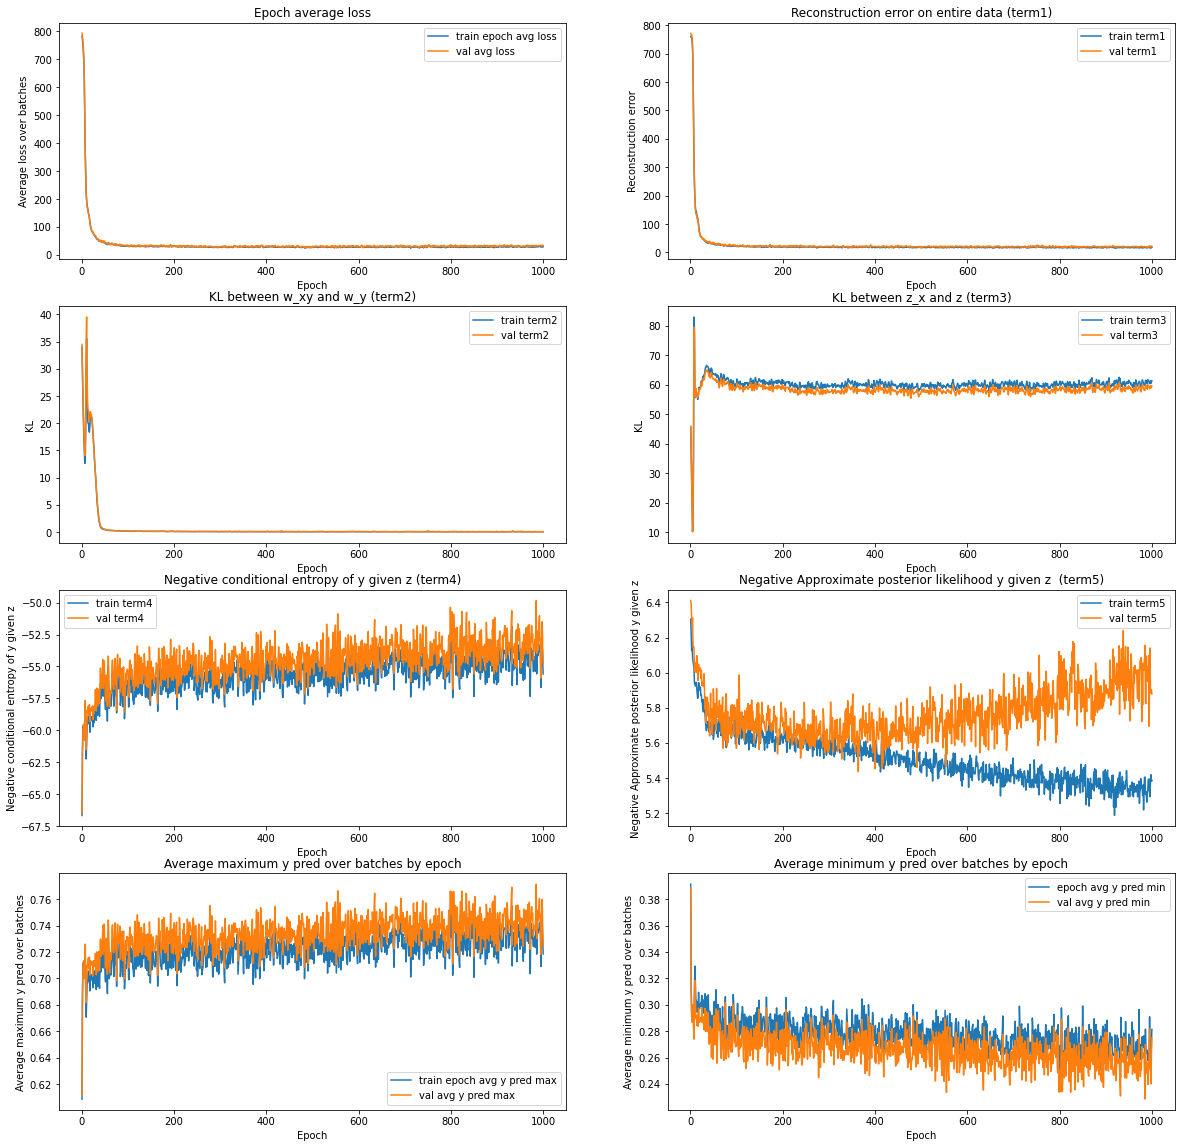

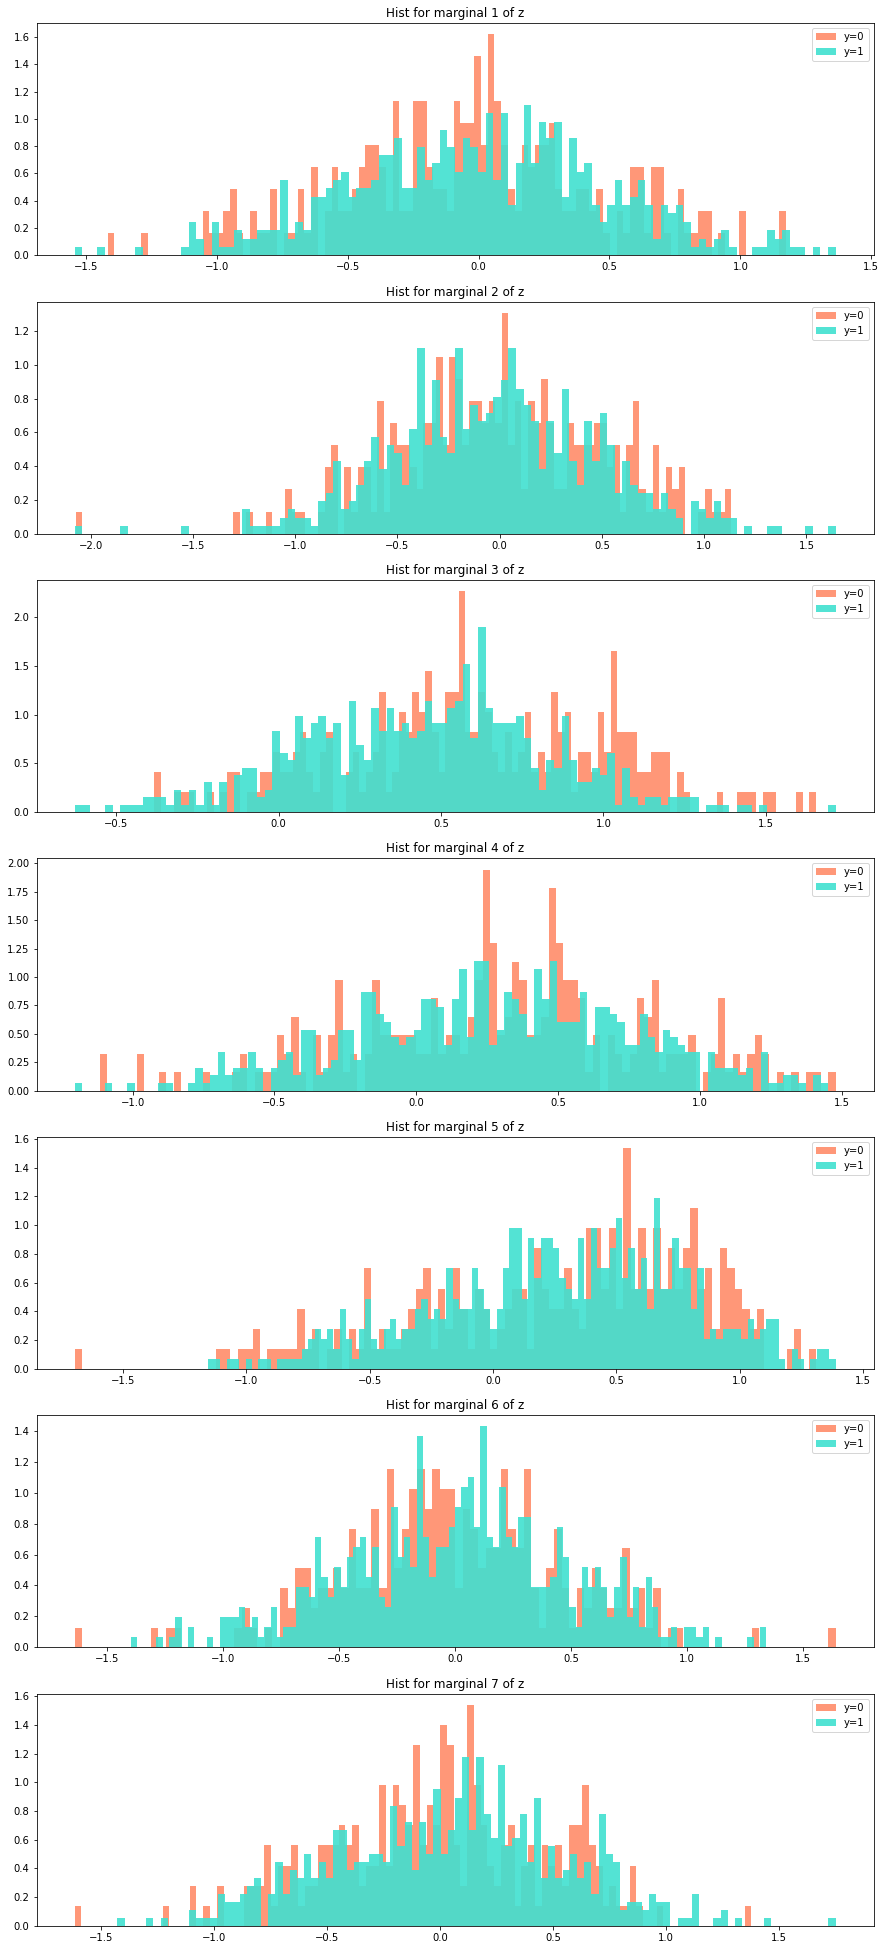

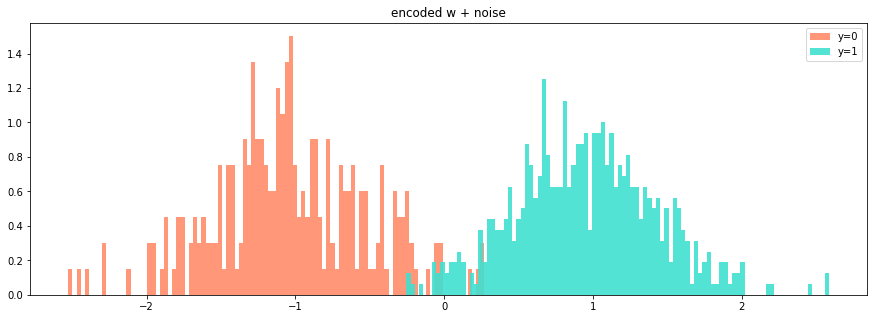

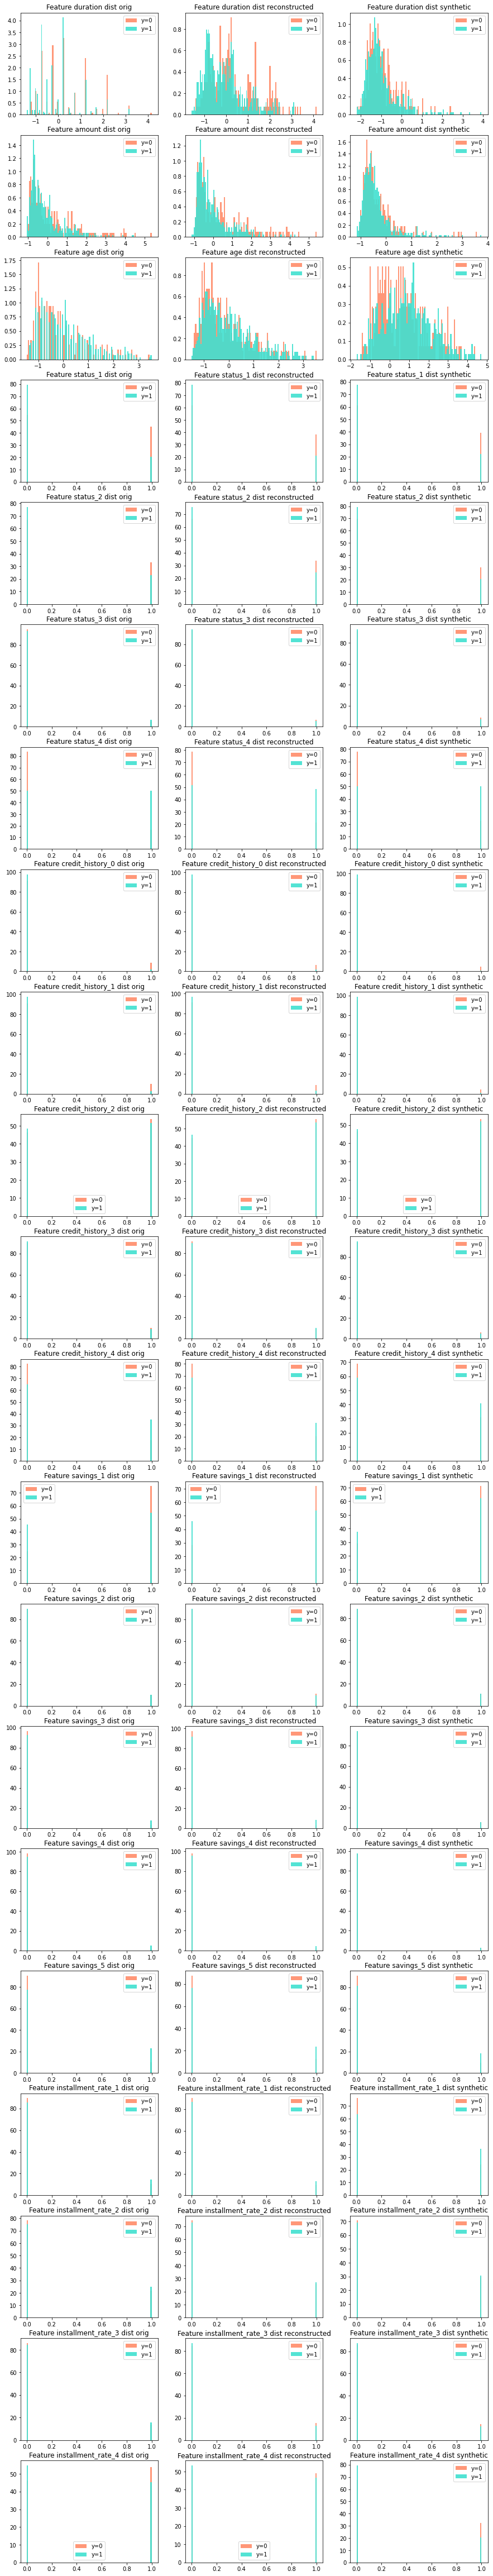

original correlations
          0         1         2         3         4         5         6   \
0   1.000000  0.618902 -0.052247  0.004531  0.099247 -0.065056 -0.061167   
1   0.618902  1.000000  0.006554 -0.038968  0.137483 -0.100874 -0.038056   
2  -0.052247  0.006554  1.000000 -0.016212 -0.056133  0.007305  0.061522   
3   0.004531 -0.038968 -0.016212  1.000000 -0.368498 -0.158797 -0.507597   
4   0.099247  0.137483 -0.056133 -0.368498  1.000000 -0.151408 -0.483978   
5  -0.065056 -0.100874  0.007305 -0.158797 -0.151408  1.000000 -0.208561   
6  -0.061167 -0.038056  0.061522 -0.507597 -0.483978 -0.208561  1.000000   
7   0.110203  0.149045 -0.008767  0.025250  0.106328 -0.000557 -0.118040   
8   0.005467 -0.009828  0.009382  0.115297  0.018725  0.018212 -0.131206   
9  -0.056986 -0.103011 -0.160762  0.047343 -0.009585  0.045894 -0.057213   
10  0.163400  0.136815  0.013459 -0.100186  0.109056 -0.044736  0.015949   
11 -0.091005 -0.033909  0.166475 -0.052510 -0.112942 -0.030053  0.

[[0.42 0.58]]


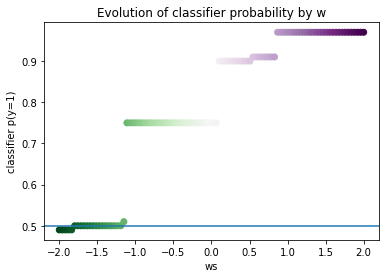

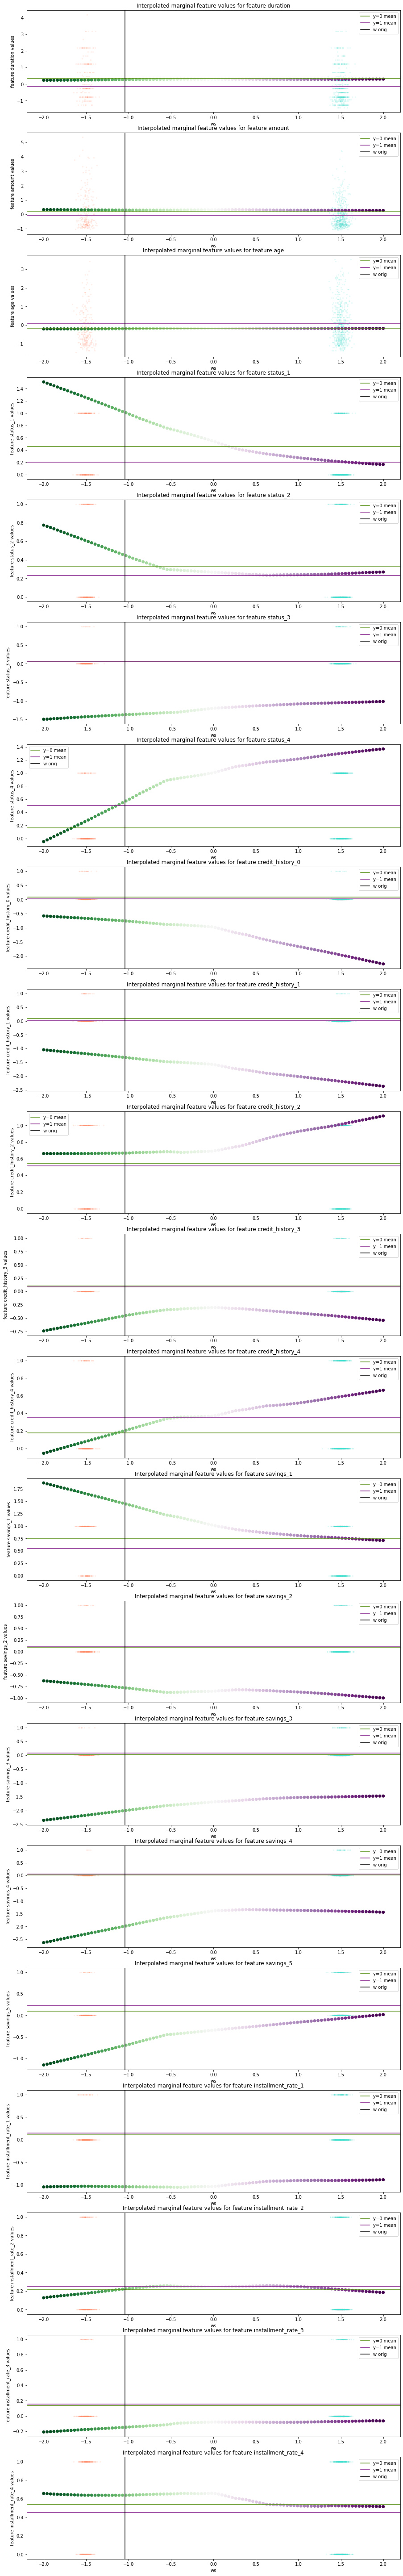

ValueError: Image size of 1080x105840 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x105840 with 420 Axes>

In [230]:
 likelihood_partition = {
                (0, 2): 'real',
                (3, 6): 'categorical',
                (7, 11): 'categorical',
                (12, 16): 'categorical',
                 (17, 20): 'categorical' 
            }
    
train_dataset = SGCDataset(X=X_train, y=y_train)
val_dataset = SGCDataset(X=X_test, y=y_test)

likelihood_params = {'lik_var' : 0.1**2, 'lik_var_lognormal': 0.1**2, 'binomial_num_trials': 20}

csvae = CSVAE(x_dim=train_dataset.data.shape[1], 
              y_dim=2, 
              z_dim=7, 
              w_dim=1, 
              z_prior_var=CSVAE_Z_PRIOR_VAR,
              likelihood_partition=likelihood_partition,
              likelihood_params=likelihood_params,
              beta1=CSVAE_BETA1, 
              beta2=CSVAE_BETA2, 
              beta3=CSVAE_BETA3, 
              beta4=CSVAE_BETA4,
              beta5=CSVAE_BETA5
             )


csvae.set_train_dataset(train_dataset, featnames=featnames)
csvae.set_val_dataset(val_dataset)
csvae.train(num_epochs=CSVAE_NUM_EPOCHS)

plot_history_csvae(csvae)
debug_nd_csvae(csvae, do_scatterplots=False)
#debug_nd_csvae(csvae, experiment_instance_output_dir, use_val=True)

# see effect of changing class
x_y0_exemplar = torch.from_numpy(csvae.train_X_numpy[csvae.train_y_numpy == 0].mean(axis=0).reshape(1, -1).astype('float32'))
x_y0_exemplar_numpy = x_y0_exemplar.detach().numpy()

X_train = csvae.train_X_numpy
y_train = csvae.train_y_numpy

rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=None,
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0,
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None, 
                            ccp_alpha=0.0, 
                            max_samples=None)
rf.fit(X_train, y_train)

print(rf.predict_proba(x_y0_exemplar_numpy))

debug_class_change_csvae(csvae, x_y0_exemplar, np.array([0.]), w_range=None, clf=rf)

In [224]:
print(X_train[y_train == 0, :].mean(axis=0)[3:])
print(X_train[y_train == 1, :].mean(axis=0)[3:])

[0.45378152 0.33193278 0.05042017 0.16386555 0.0882353  0.09663866
 0.53781515 0.10084034 0.1764706  0.7521008  0.10084034 0.03361345
 0.01680672 0.09663866 0.10504202 0.2184874  0.13865547 0.53781515]
[0.20462634 0.22953737 0.0658363  0.5        0.02135231 0.02491103
 0.5160142  0.08718861 0.3505338  0.54448396 0.10320285 0.07473309
 0.04982206 0.227758   0.14590748 0.24733096 0.15480427 0.4519573 ]


In [225]:
samples = csvae.unconditional_sample(S=10000, y=csvae.train_y)

print(samples[csvae.train_y.flatten() == 0].mean(axis=0)[3:])
print(samples[csvae.train_y.flatten() == 1].mean(axis=0)[3:])


tensor([0.3866, 0.3571, 0.0714, 0.1849, 0.0924, 0.0966, 0.5294, 0.1008, 0.1807,
        0.7647, 0.0378, 0.0924, 0.0252, 0.0798, 0.1681, 0.3445, 0.1639, 0.3235])
tensor([0.2117, 0.2046, 0.0498, 0.5338, 0.0125, 0.0142, 0.5249, 0.0427, 0.4057,
        0.6210, 0.0836, 0.0979, 0.0249, 0.1726, 0.3025, 0.3843, 0.1263, 0.1868])
